# Распознавание писателей

## Подготовка данных

### Import библиотек

In [ ]:
from google.colab import files #модуль для загрузки файлов в colab
import numpy as np #библиотека для работы с массивами данных
import pandas as pd #библиотека для обработки и анализа данных
import matplotlib.pyplot as plt #библиотека для визуализации данных
# "Магическая"команда python для запуска библиотеки в ноутбуке
%matplotlib inline

from tensorflow.keras import utils #модуль с утилитами кераса, будем использовать для вызова метода преобразования категорий в вектора
from tensorflow.keras.models import Sequential #последовательная модель нейросети кераса
# Загружаем стандартные слои нейросети(полносвязный, регуляризации, нормализации, векторного представления слов, выравнивания, активации)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# Загружаем сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# Загружаем рекуррентные слои
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
# Загружаем алгоритмы обучения/оптимизации
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.preprocessing.text import Tokenizer, text_to_word_sequence #инструменты предобработки текста от кераса
from sklearn.model_selection import train_test_split #модуль для разбиения данных на обучающую и тестовую выборки
from tensorflow.keras.utils import plot_model
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Загрузка данных


In [ ]:
###########################
# Чтение файла в текст
##########################
def readText(fileName): # функция принимает имя файла
  f = open(fileName, 'r')        # задаем открытие нужного файла в режиме чтения
  text = f.read()                # читаем текст
  text = text.replace("\n", " ") # переносы строки переводим в пробелы
  
  return text                    # функция возвращает текст файла

# Загружаем обучающие тексты
trainText = []
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(О. Генри) Обучающая_50 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Стругацкие) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Булгаков) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Клиффорд_Саймак) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Макс Фрай) Обучающая_5 вместе.txt'))
trainText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Рэй Брэдберри) Обучающая_22 вместе.txt')) 

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдбери"]
nClasses = len(className)

# Загружаем тестовые тексты
testText = []
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(О. Генри) Тестовая_20 вместе.txt'))
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Стругацкие) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Булгаков) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Клиффорд_Саймак) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Макс Фрай) Тестовая_2 вместе.txt'))
testText.append(readText('/content/drive/My Drive/Базы/Тексты писателей/(Рэй Брэдберри) Тестовая_8 вместе.txt'))

### Обработка данных


In [ ]:
#################
# Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 20000 # определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

# для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower=True, split=' ', char_level=False, oov_token = 'unknown')
# выше задаем параметры:
# (num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# (filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
# (lower=True) - приводим слова к нижнему регистру
# (split=' ') - разделяем слова по пробелу
# (char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(trainText) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) #вытаскиваем индексы слов для просмотра

In [ ]:
print(items[:100]) # взглянем на содержимое словаря

[('unknown', 1), ('и', 2), ('в', 3), ('не', 4), ('я', 5), ('что', 6), ('на', 7), ('с', 8), ('он', 9), ('а', 10), ('как', 11), ('то', 12), ('это', 13), ('но', 14), ('все', 15), ('у', 16), ('по', 17), ('его', 18), ('к', 19), ('так', 20), ('мне', 21), ('из', 22), ('за', 23), ('меня', 24), ('ты', 25), ('же', 26), ('сказал', 27), ('бы', 28), ('было', 29), ('вы', 30), ('от', 31), ('они', 32), ('мы', 33), ('только', 34), ('да', 35), ('еще', 36), ('она', 37), ('о', 38), ('когда', 39), ('вот', 40), ('уже', 41), ('если', 42), ('был', 43), ('ни', 44), ('их', 45), ('нет', 46), ('чтобы', 47), ('до', 48), ('ну', 49), ('для', 50), ('ему', 51), ('может', 52), ('или', 53), ('ничего', 54), ('даже', 55), ('там', 56), ('очень', 57), ('кто', 58), ('ее', 59), ('тут', 60), ('потом', 61), ('просто', 62), ('него', 63), ('чем', 64), ('быть', 65), ('теперь', 66), ('под', 67), ('где', 68), ('нас', 69), ('есть', 70), ('тебя', 71), ('время', 72), ('ли', 73), ('тебе', 74), ('со', 75), ('во', 76), ('вас', 77), ('раз'

In [ ]:
print("Протестируем словарь частотности")
print("Интересующее слово имеет индекс: ", tokenizer.word_index[input("уточните слово: ")]) #протестируем словарь частотности

Протестируем словарь частотности
уточните слово: корабль
Интересующее слово имеет индекс:  2493


In [ ]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)   # проверочные тесты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[1] [:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20])

print()
print()

print("Статистика по обучающим текстам:")
for i in range(6):
  print(className[i], " ", len(trainText[i]), " символов, ", len(trainWordIndexes[i]), " слов")
print("В сумме ", len(trainText[0])+len(trainText[1])+len(trainText[2])+len(trainText[3])+len(trainText[4])+len(trainText[5]), " символов, ", len(trainWordIndexes[0])+len(trainWordIndexes[1])+len(trainWordIndexes[2])+len(trainWordIndexes[3])+len(trainWordIndexes[4])+len(trainWordIndexes[5]), " слов")
print()
print("Статистика по обучающим текстам:")
for i in range(6):
  print(className[i], " ", len(testText[i]), " символов, ", len(testWordIndexes[i]), " слов")
print("В сумме ", len(testText[0])+len(testText[1])+len(testText[2])+len(testText[3])+len(testText[4])+len(testText[5]), " символов, ", len(testWordIndexes[0])+len(testWordIndexes[1])+len(testWordIndexes[2])+len(testWordIndexes[3])+len(testWordIndexes[4])+len(testWordIndexes[5]), " слов")

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               Парень из преисподней     1     Ну и деревня! Сроду я таких деревень не видел и не знал
Он же в виде последовательности индексов:  [470, 22, 1, 1482, 49, 2, 12725, 7723, 5, 415, 1, 4, 252, 2, 4, 247, 55, 6, 240, 10517]


Статистика по обучающим текстам:
О. Генри   1049517  символов,  160682  слов
Стругацкие   2042469  символов,  313405  слов
Булгаков   1765648  символов,  262109  слов
Саймак   1609507  символов,  251551  слов
Фрай   3700010  символов,  569052  слов
Брэдбери   1386454  символов,  214694  слов
В сумме  11553605  символов,  1771493  слов

Статистика по обучающим текстам:
О. Генри   349662  символов,  53255  слов
Стругацкие   704846  символов,  108730  слов
Булгаков   875042  символов,  132910  слов
Саймак   318811  символов,  50362  слов
Фрай   1278191  символов,  196911  слов
Брэдбери   868673  символов,  132746  слов
В сумме  4395225  символов,  674914  слов


### Создание обучающей и проверочной выборки

**Функции для формирования выборки по отрезкам текста с заданным шагом**

In [ ]:
###########################
# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
##########################
def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0
  
  # Идём по всей длине вектора индексов
  # "Откусываем" векторы длины xLen и смещаеммся вперёд на step
  
  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
    
  return xSample

In [ ]:
###########################
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
##########################
def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов выборки
  classesXSamples = []        # здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна(например 6 по 1341*1000)"
  for wI in wordIndexes:      # для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна(например 15779*1000)"
  ySamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses):  # в диапазоне кол-ва классов(6)
    xT = classesXSamples[t]  # берем очередной текст вида "кол-во окон в тексте*длину окна"(например 1341*1000)
    for i in range(len(xT)): # и каждое его окно
      xSamples.append(xT[i]) # добавляем в общий список выборки
    
    # Формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 6 вида [0.0.0.1.0.0.]
    for i in range(len(xT)): # на каждое окно выборки 
      ySamples.append(currY) # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

**Подготовка данных**

In [ ]:
# Задаём базовые параметры
xLen = 1000 # Длина отрезка текста, по которой анализируем, в словах
step = 100 # Шаг разбиения исходного текста на обучающие вектора

In [ ]:
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
# получили обучающий/тестовый набор, достаточный для запуска Embedding, но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1

(17658, 1000)
(17658, 6)
(6693, 1000)
(6693, 6)


### Распознавание проверочной выборки


In [ ]:
###########################
# Представляем тестовую выборку в удобных для распознавания размерах
##########################
def createTestMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём тестовую выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов
  xTest6Classes01 = []               # здесь будет список из всех классов,каждый размером "кол-во окон в тексте * 20000(при maxWordsCount=20000)"
  xTest6Classes = []                 # здесь будет список массивов, каждый размером "кол-во окон в тексте * длину окна"(6 по 420*1000)
  for wI in wordIndexes:             # для каждого тестового текста из последовательности индексов
    sample = (getSetFromIndexes(wI, xLen, step)) # тестовая выборка размером "кол-во окон*длину окна"(например 420*1000)
    xTest6Classes.append(np.array(sample))       # переводим в массив numpy и добавляем в список
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) # трансформируется в Bag of Words в виде "кол-во окон в тексте * 20000"
  xTest6Classes01 = np.array(xTest6Classes01)                     # и добавляется к нашему списку, 
  
  return xTest6Classes01, xTest6Classes # функция вернёт тестовые данные: TestBg 6 классов на n*20000 и xTestEm 6 по n*1000

###########################
# Расспознаём тестовую выборку и выводим результаты
##########################
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  val = []
  pred = []
  
  totalSumRec = []
  
  # Проходим по всем классам
  for i in range(nClasses):
    # Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    pred.append(currPred)
    # Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)
    
    # Считаем процент распознавания каждого класса за каждый
    # Получам матрицу 6 на 6
    evVal = []
    sumRec = []
    for j in range(nClasses):
      sumRec.append(0)
      for t in range(len(currOut)):
        if (currOut[t] == j):
          sumRec[j] += 1
      evVal.append(sumRec[j] / len(currOut))
    
    totalSumRec.append(sumRec[i])
    
    # Определяем, какой в класс в итоге за какой был распознан
    val.append(evVal[i])
    recognizedClass = np.argmax(evVal)
    
    # Выводим результаты распознавания по текущему классу
    isRecognized = "распознано НЕ ВЕРНО!"
    if (recognizedClass == i):
      isRecognized = "распознано ВЕРНО!"
    print(className[i], " распознано ", int(100*evVal[i]), "% сеть считает, что это ", className[recognizedClass], ", ", isRecognized)
  
  # Выводим вредний процент распознавания по всем классам вместе
  print()
  sumVal = 0
  sumCount = 0
  lenXtest = []
  for i in range(nClasses):
    sumCount += len(xTest[i])
    sumVal += totalSumRec[i]
  print("Средний процент распознавания ", int(100*sumVal/sumCount), "%")
  print()
  return sumVal/sumCount

xTest6Classes01, xTest6Classes = createTestMultiClasses(testWordIndexes, xLen, step) # подгоним форму тестовых классов под функцию recognizeMultiClass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


## Эксперименты

### Simple RNN

####**Иссл. №1**

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1000, 5)           20        
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 4)                 40        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 30        
Total params: 100,090
Trainable params: 100,080
Non-trainable params: 10
_______________________________________________

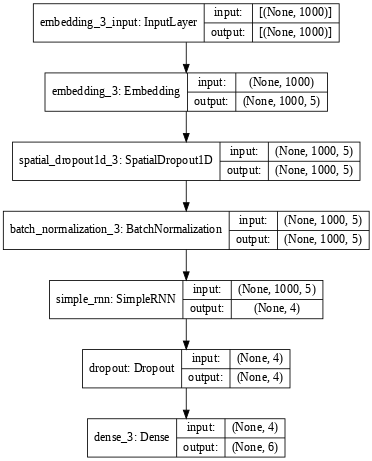

In [ ]:
modelSimpleRNN = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelSimpleRNN.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelSimpleRNN.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelSimpleRNN.add(BatchNormalization()) # добавляем слой нормализации данных
modelSimpleRNN.add(SimpleRNN(4))
modelSimpleRNN.add(Dropout(0.2))
modelSimpleRNN.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelSimpleRNN.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelSimpleRNN.summary() # Выводим summary модели
print()
plot_model(modelSimpleRNN, dpi=60, show_shapes=True) # Выводим схему модели

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelSimpleRNN.fit(xTrain, 
                    yTrain, 
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/50
35/35 [==============================] - 22s 603ms/step - loss: 1.8411 - accuracy: 0.1807 - val_loss: 1.8124 - val_accuracy: 0.2928
Epoch 2/50
35/35 [==============================] - 21s 592ms/step - loss: 1.7539 - accuracy: 0.2535 - val_loss: 1.8070 - val_accuracy: 0.2928
Epoch 3/50
35/35 [==============================] - 21s 602ms/step - loss: 1.6943 - accuracy: 0.3163 - val_loss: 1.8112 - val_accuracy: 0.2928
Epoch 4/50
35/35 [==============================] - 21s 593ms/step - loss: 1.6364 - accuracy: 0.3596 - val_loss: 1.8197 - val_accuracy: 0.2928
Epoch 5/50
35/35 [==============================] - 21s 604ms/step - loss: 1.5863 - accuracy: 0.3869 - val_loss: 1.8340 - val_accuracy: 0.2996
Epoch 6/50
35/35 [==============================] - 21s 594ms/step - loss: 1.5372 - accuracy: 0.4117 - val_loss: 1.7957 - val_accuracy: 0.3202
Epoch 7/50
35/35 [==============================] - 20s 585ms/step - loss: 1.4841 - accuracy: 0.4364 - val_loss: 1.7573 - val_accuracy: 0.3239

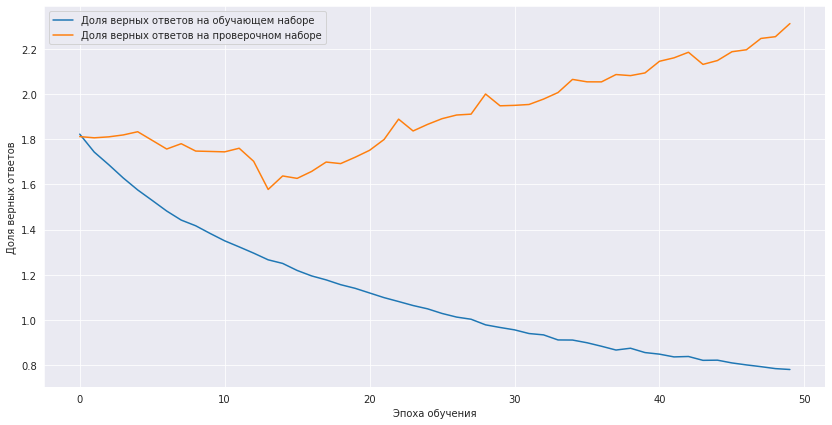

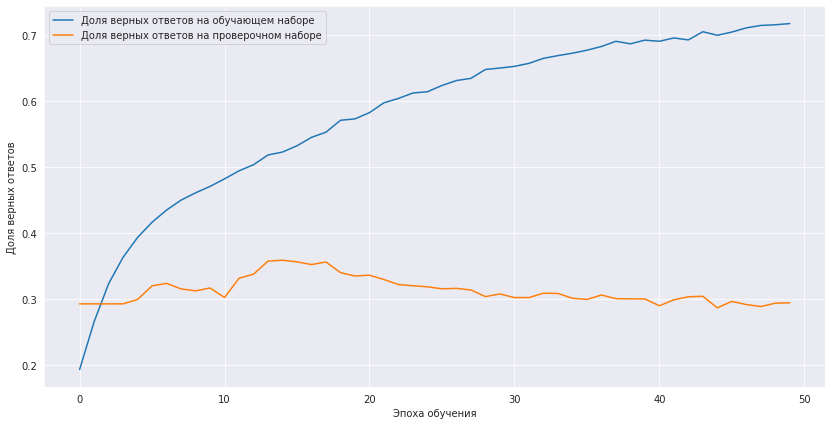

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(modelSimpleRNN, xTest6Classes, "SimpleRNN") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  SimpleRNN

О. Генри  распознано  14 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  20 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  18 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Саймак  распознано  14 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Фрай  распознано  61 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  12 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!

Средний процент распознавания  29 %



####**Иссл. №2**

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1000, 5)           20        
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                520       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 126       
Total params: 100,666
Trainable params: 100,656
Non-trainable params: 10
_______________________________________________

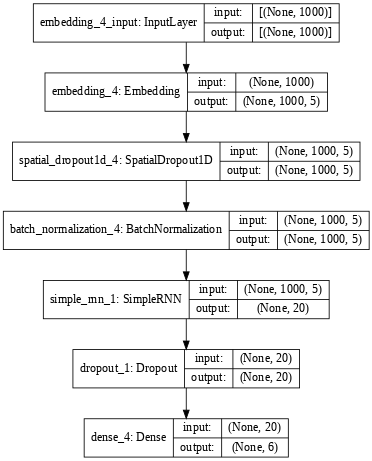

In [ ]:
modelSimpleRNN_2 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelSimpleRNN_2.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelSimpleRNN_2.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelSimpleRNN_2.add(BatchNormalization()) # добавляем слой нормализации данных
modelSimpleRNN_2.add(SimpleRNN(20))
modelSimpleRNN_2.add(Dropout(0.2))
modelSimpleRNN_2.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelSimpleRNN_2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelSimpleRNN_2.summary() # Выводим summary модели
print()
plot_model(modelSimpleRNN_2, dpi=60, show_shapes=True) # Выводим схему модели

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelSimpleRNN_2.fit(xTrain, 
                    yTrain, 
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/50
35/35 [==============================] - 21s 579ms/step - loss: 1.9148 - accuracy: 0.1881 - val_loss: 1.7609 - val_accuracy: 0.2928
Epoch 2/50
35/35 [==============================] - 20s 574ms/step - loss: 1.7594 - accuracy: 0.2709 - val_loss: 1.8105 - val_accuracy: 0.2928
Epoch 3/50
35/35 [==============================] - 20s 573ms/step - loss: 1.6557 - accuracy: 0.3431 - val_loss: 1.9128 - val_accuracy: 0.2928
Epoch 4/50
35/35 [==============================] - 20s 568ms/step - loss: 1.5800 - accuracy: 0.3938 - val_loss: 1.9347 - val_accuracy: 0.2940
Epoch 5/50
35/35 [==============================] - 20s 568ms/step - loss: 1.5381 - accuracy: 0.4121 - val_loss: 1.9584 - val_accuracy: 0.2928
Epoch 6/50
35/35 [==============================] - 20s 572ms/step - loss: 1.4984 - accuracy: 0.4309 - val_loss: 1.9983 - val_accuracy: 0.2948
Epoch 7/50
35/35 [==============================] - 20s 575ms/step - loss: 1.4476 - accuracy: 0.4441 - val_loss: 2.0082 - val_accuracy: 0.2948

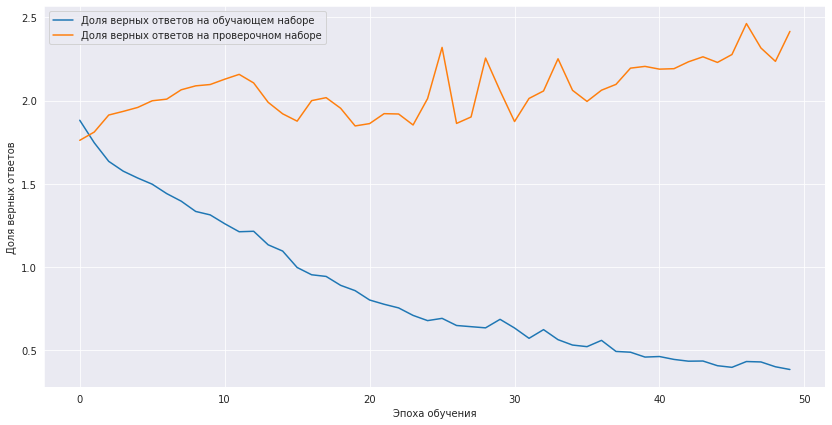

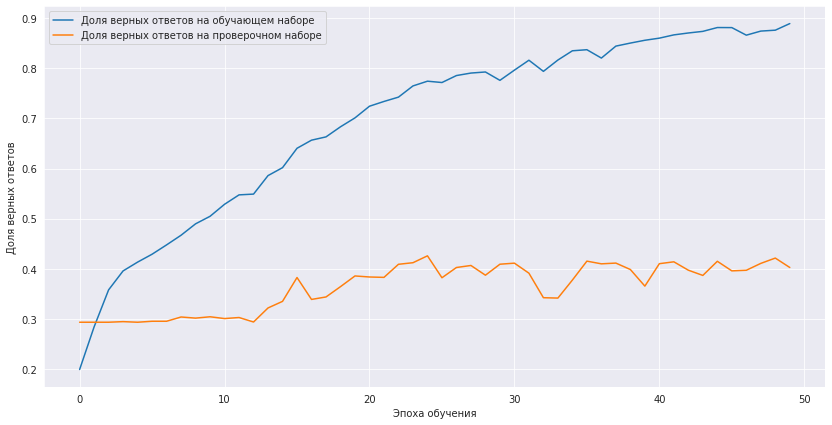

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(modelSimpleRNN_2, xTest6Classes, "SimpleRNN") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  SimpleRNN

О. Генри  распознано  21 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  32 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  19 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Саймак  распознано  28 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Фрай  распознано  73 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  29 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  40 %



####**Иссл. №3**

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 100)         2000000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 1000, 100)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1000, 100)         400       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20)                2420      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 126       
Total params: 2,002,946
Trainable params: 2,002,746
Non-trainable params: 200
__________________________________________

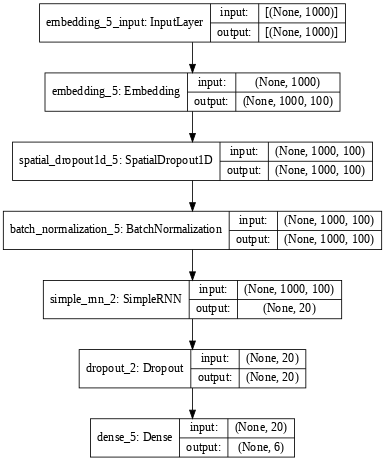

In [ ]:
modelSimpleRNN_3 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelSimpleRNN_3.add(Embedding(maxWordsCount, 100, input_length=xLen))

modelSimpleRNN_3.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelSimpleRNN_3.add(BatchNormalization()) # добавляем слой нормализации данных
modelSimpleRNN_3.add(SimpleRNN(20))
modelSimpleRNN_3.add(Dropout(0.2))
modelSimpleRNN_3.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelSimpleRNN_3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelSimpleRNN_3.summary() # Выводим summary модели
print()
plot_model(modelSimpleRNN_3, dpi=60, show_shapes=True) # Выводим схему модели

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelSimpleRNN_3.fit(xTrain, 
                    yTrain, 
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/50
35/35 [==============================] - 26s 701ms/step - loss: 2.0184 - accuracy: 0.1998 - val_loss: 1.8509 - val_accuracy: 0.2928
Epoch 2/50
35/35 [==============================] - 24s 693ms/step - loss: 1.6634 - accuracy: 0.3399 - val_loss: 1.9875 - val_accuracy: 0.2928
Epoch 3/50
35/35 [==============================] - 24s 699ms/step - loss: 1.4844 - accuracy: 0.4319 - val_loss: 2.2330 - val_accuracy: 0.2928
Epoch 4/50
35/35 [==============================] - 25s 711ms/step - loss: 1.3045 - accuracy: 0.5208 - val_loss: 2.5509 - val_accuracy: 0.2955
Epoch 5/50
35/35 [==============================] - 25s 706ms/step - loss: 1.1302 - accuracy: 0.5984 - val_loss: 2.8673 - val_accuracy: 0.2982
Epoch 6/50
35/35 [==============================] - 25s 701ms/step - loss: 0.9871 - accuracy: 0.6569 - val_loss: 2.8688 - val_accuracy: 0.3120
Epoch 7/50
35/35 [==============================] - 24s 692ms/step - loss: 0.8513 - accuracy: 0.7172 - val_loss: 3.0908 - val_accuracy: 0.3226

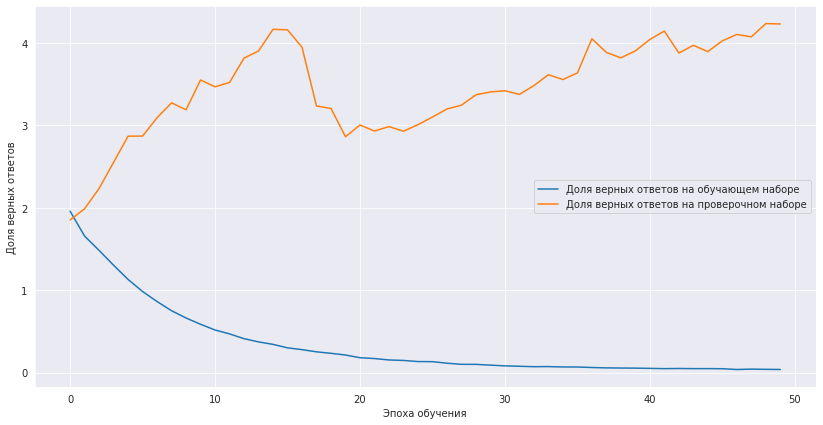

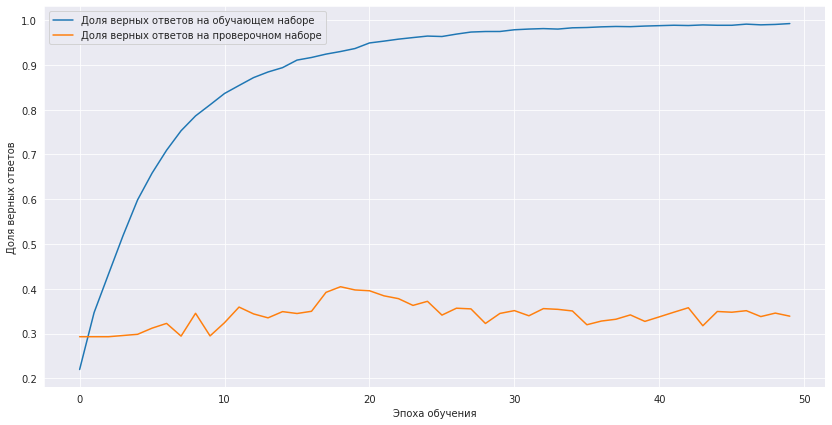

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(modelSimpleRNN_3, xTest6Classes, "SimpleRNN") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  SimpleRNN

О. Генри  распознано  21 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  21 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  17 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Саймак  распознано  30 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  65 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  19 % сеть считает, что это  Саймак ,  распознано НЕ ВЕРНО!

Средний процент распознавания  33 %



####**Иссл. №4**

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 1000, 5)           20        
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 20)                520       
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 126       
Total params: 100,666
Trainable params: 100,656
Non-trainable params: 10
_______________________________________________

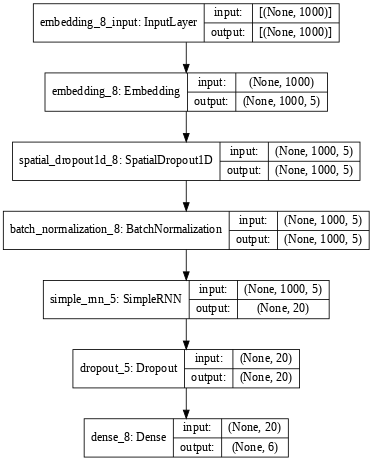

In [ ]:
modelSimpleRNN_4 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelSimpleRNN_4.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelSimpleRNN_4.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelSimpleRNN_4.add(BatchNormalization()) # добавляем слой нормализации данных
modelSimpleRNN_4.add(SimpleRNN(20))
modelSimpleRNN_4.add(Dropout(0.4))
modelSimpleRNN_4.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelSimpleRNN_4.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelSimpleRNN_4.summary() # Выводим summary модели
print()
plot_model(modelSimpleRNN_4, dpi=60, show_shapes=True) # Выводим схему модели

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelSimpleRNN_4.fit(xTrain, 
                    yTrain, 
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/50
35/35 [==============================] - 21s 577ms/step - loss: 2.0183 - accuracy: 0.1712 - val_loss: 1.7755 - val_accuracy: 0.2928
Epoch 2/50
35/35 [==============================] - 20s 576ms/step - loss: 1.8459 - accuracy: 0.2200 - val_loss: 1.7812 - val_accuracy: 0.2928
Epoch 3/50
35/35 [==============================] - 20s 580ms/step - loss: 1.7833 - accuracy: 0.2667 - val_loss: 1.7630 - val_accuracy: 0.2928
Epoch 4/50
35/35 [==============================] - 20s 573ms/step - loss: 1.7340 - accuracy: 0.2974 - val_loss: 1.7442 - val_accuracy: 0.3172
Epoch 5/50
35/35 [==============================] - 20s 577ms/step - loss: 1.6659 - accuracy: 0.3393 - val_loss: 1.7703 - val_accuracy: 0.3253
Epoch 6/50
35/35 [==============================] - 20s 581ms/step - loss: 1.5727 - accuracy: 0.3972 - val_loss: 1.9461 - val_accuracy: 0.2364
Epoch 7/50
35/35 [==============================] - 20s 578ms/step - loss: 1.5132 - accuracy: 0.4080 - val_loss: 2.0200 - val_accuracy: 0.2902

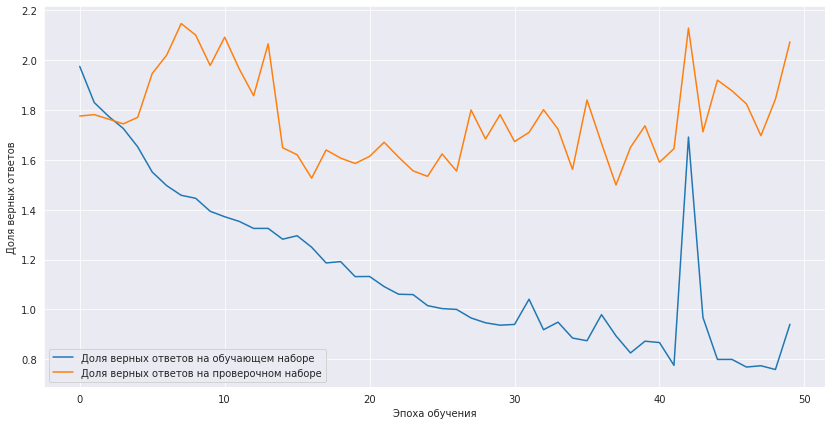

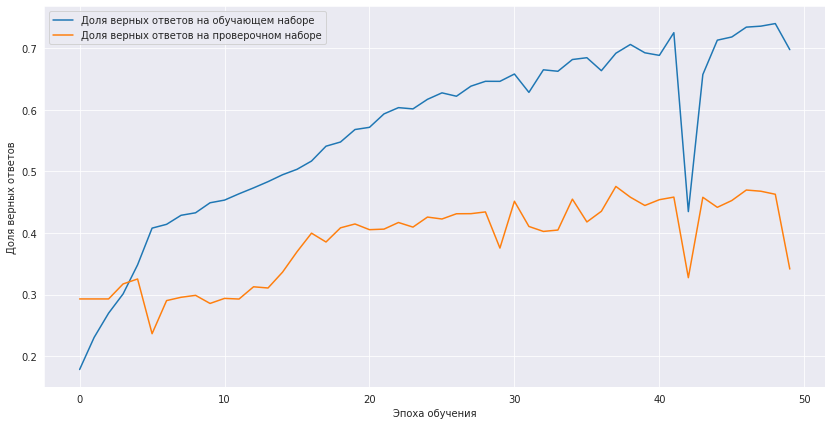

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(modelSimpleRNN_4, xTest6Classes, "SimpleRNN") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  SimpleRNN

О. Генри  распознано  3 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  25 % сеть считает, что это  Саймак ,  распознано НЕ ВЕРНО!
Булгаков  распознано  8 % сеть считает, что это  Саймак ,  распознано НЕ ВЕРНО!
Саймак  распознано  44 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  55 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  43 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  34 %



### GRU

####**Иссл. №5**

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 1000, 5)           20        
_________________________________________________________________
gru_3 (GRU)                  (None, 4)                 132       
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 30        
Total params: 100,182
Trainable params: 100,172
Non-trainable params: 10
_________________________________________________________________



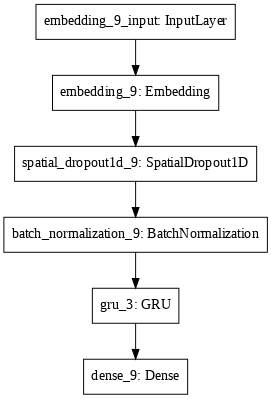

In [ ]:
modelGRU_1 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelGRU_1.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelGRU_1.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelGRU_1.add(BatchNormalization()) # добавляем слой нормализации данных
modelGRU_1.add(GRU(4, dropout=0.2, recurrent_dropout=0.2, activation="relu"))
modelGRU_1.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelGRU_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelGRU_1.summary()
print()
plot_model(modelGRU_1, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelGRU_1.fit(xTrain, 
                    yTrain, 
                    epochs=40,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/40
35/35 [==============================] - 89s 2s/step - loss: 1.8683 - accuracy: 0.1417 - val_loss: 1.7780 - val_accuracy: 0.2928
Epoch 2/40
35/35 [==============================] - 86s 2s/step - loss: 1.7770 - accuracy: 0.2582 - val_loss: 1.7664 - val_accuracy: 0.2928
Epoch 3/40
35/35 [==============================] - 85s 2s/step - loss: 1.7169 - accuracy: 0.3222 - val_loss: 1.7504 - val_accuracy: 0.2928
Epoch 4/40
35/35 [==============================] - 85s 2s/step - loss: 1.6324 - accuracy: 0.3370 - val_loss: 1.7397 - val_accuracy: 0.2928
Epoch 5/40
35/35 [==============================] - 85s 2s/step - loss: 1.5448 - accuracy: 0.3556 - val_loss: 1.7343 - val_accuracy: 0.2928
Epoch 6/40
35/35 [==============================] - 85s 2s/step - loss: 1.4227 - accuracy: 0.3991 - val_loss: 1.7364 - val_accuracy: 0.2924
Epoch 7/40
35/35 [==============================] - 85s 2s/step - loss: 1.3072 - accuracy: 0.4478 - val_loss: 1.7437 - val_accuracy: 0.3371
Epoch 8/40
35/35 [==

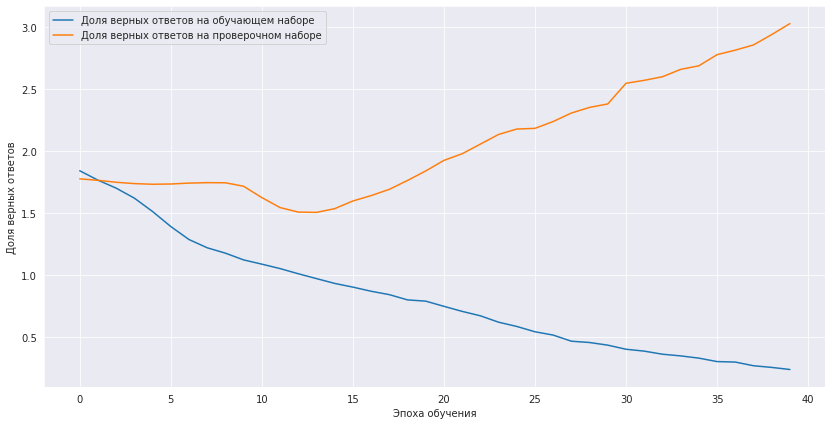

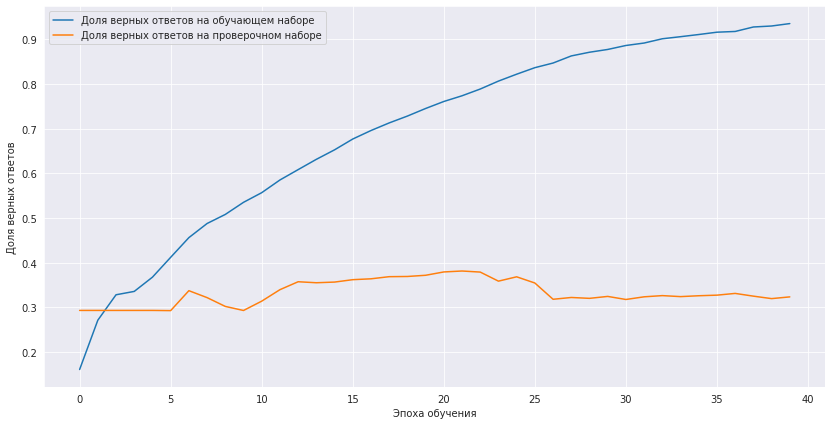

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(modelGRU_1, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  49 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  4 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Булгаков  распознано  38 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Саймак  распознано  70 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  3 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Брэдбери  распознано  70 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  32 %



####**Иссл. №6**

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_17 (Spatia (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 1000, 5)           20        
_________________________________________________________________
gru_2 (GRU)                  (None, 40)                5640      
_________________________________________________________________
dense_27 (Dense)             (None, 6)                 246       
Total params: 105,906
Trainable params: 105,896
Non-trainable params: 10
_________________________________________________________________



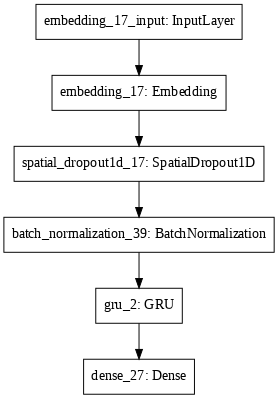

In [ ]:
modelGRU_2 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelGRU_2.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelGRU_2.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelGRU_2.add(BatchNormalization()) # добавляем слой нормализации данных
modelGRU_2.add(GRU(40, dropout=0.4, recurrent_dropout=0.4, activation="relu"))
modelGRU_2.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelGRU_2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelGRU_2.summary()
print()
plot_model(modelGRU_2, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelGRU_2.fit(xTrain, 
                    yTrain, 
                    epochs=50,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/50
35/35 [==============================] - 134s 4s/step - loss: 1.7539 - accuracy: 0.2414 - val_loss: 1.7419 - val_accuracy: 0.2928
Epoch 2/50
35/35 [==============================] - 130s 4s/step - loss: 1.6803 - accuracy: 0.3243 - val_loss: 1.7525 - val_accuracy: 0.2928
Epoch 3/50
35/35 [==============================] - 130s 4s/step - loss: 1.6402 - accuracy: 0.3250 - val_loss: 1.7588 - val_accuracy: 0.2928
Epoch 4/50
35/35 [==============================] - 130s 4s/step - loss: 1.5294 - accuracy: 0.3396 - val_loss: 1.7854 - val_accuracy: 0.1623
Epoch 5/50
35/35 [==============================] - 130s 4s/step - loss: 1.4387 - accuracy: 0.4298 - val_loss: 1.7946 - val_accuracy: 0.1956
Epoch 6/50
35/35 [==============================] - 130s 4s/step - loss: 1.2981 - accuracy: 0.4802 - val_loss: 1.8110 - val_accuracy: 0.2041
Epoch 7/50
35/35 [==============================] - 129s 4s/step - loss: 1.2281 - accuracy: 0.5086 - val_loss: 1.8464 - val_accuracy: 0.2027
Epoch 8/50
35

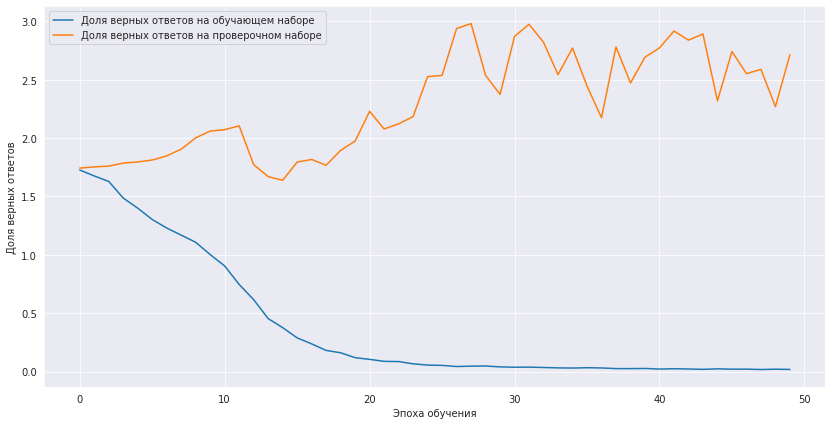

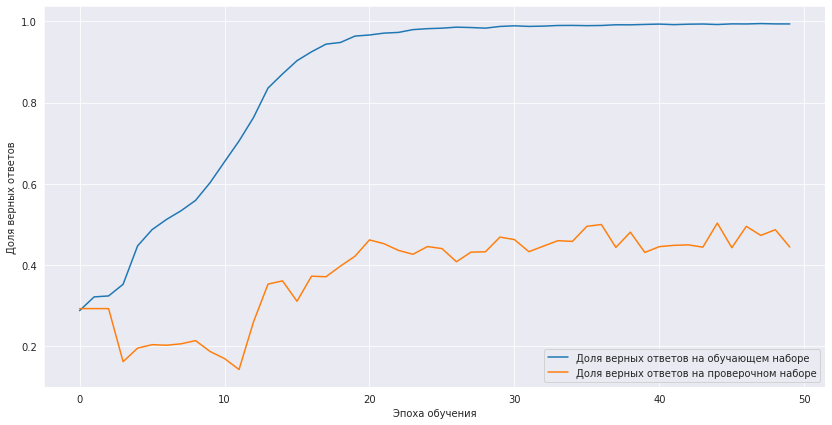

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(modelGRU_2, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  91 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  48 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  6 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Саймак  распознано  44 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Фрай  распознано  64 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  30 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!

Средний процент распознавания  44 %



####**Иссл. №7**

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 5)           20        
_________________________________________________________________
gru_2 (GRU)                  (None, 80)                20880     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 486       
Total params: 121,386
Trainable params: 121,376
Non-trainable params: 10
_________________________________________________________________



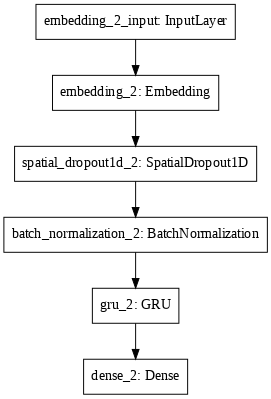

In [ ]:
modelGRU_3 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelGRU_3.add(Embedding(maxWordsCount, 5, input_length=xLen))

modelGRU_3.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelGRU_3.add(BatchNormalization()) # добавляем слой нормализации данных
modelGRU_3.add(GRU(80, dropout=0.2, recurrent_dropout=0.2, activation="relu"))
modelGRU_3.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelGRU_3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

modelGRU_3.summary()
print()
plot_model(modelGRU_3, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = modelGRU_3.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/100
35/35 [==============================] - 84s 2s/step - loss: 1.7932 - accuracy: 0.2604 - val_loss: 1.7513 - val_accuracy: 0.2928
Epoch 2/100
35/35 [==============================] - 82s 2s/step - loss: 1.6553 - accuracy: 0.3200 - val_loss: 1.7500 - val_accuracy: 0.2928
Epoch 3/100
35/35 [==============================] - 82s 2s/step - loss: 2.0519 - accuracy: 0.3563 - val_loss: 1.7441 - val_accuracy: 0.2928
Epoch 4/100
35/35 [==============================] - 82s 2s/step - loss: 1.5174 - accuracy: 0.3968 - val_loss: 1.7567 - val_accuracy: 0.2298
Epoch 5/100
35/35 [==============================] - 81s 2s/step - loss: 1.4170 - accuracy: 0.4675 - val_loss: 1.7641 - val_accuracy: 0.1682
Epoch 6/100
35/35 [==============================] - 82s 2s/step - loss: 1.2279 - accuracy: 0.5248 - val_loss: 1.7843 - val_accuracy: 0.1611
Epoch 7/100
35/35 [==============================] - 81s 2s/step - loss: 1.1221 - accuracy: 0.5552 - val_loss: 1.7656 - val_accuracy: 0.1618
Epoch 8/100
3

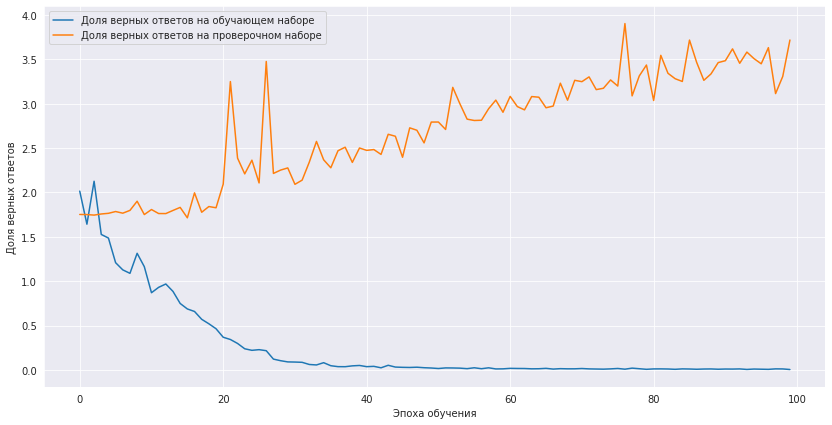

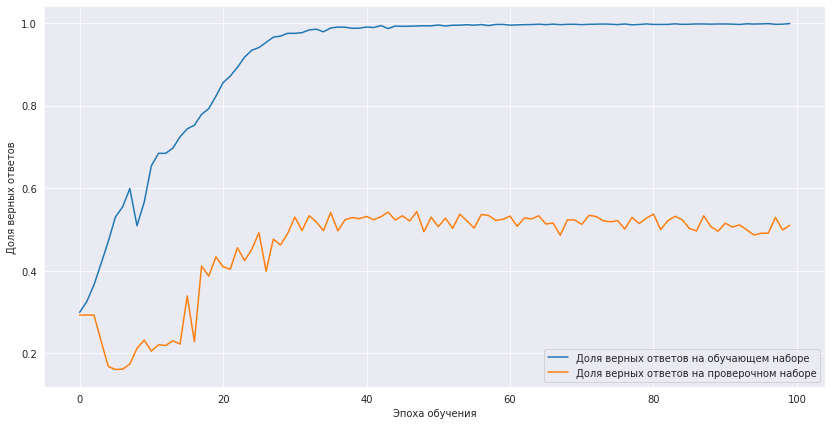

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(modelGRU_3, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  81 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  68 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  0 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Саймак  распознано  2 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Фрай  распознано  61 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  78 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  51 %



### LSTM

####**Иссл. №8**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 5)           20        
_________________________________________________________________
lstm (LSTM)                  (None, 4)                 160       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 30        
Total params: 100,210
Trainable params: 100,200
Non-trainable params: 10
_________________________________________________________________



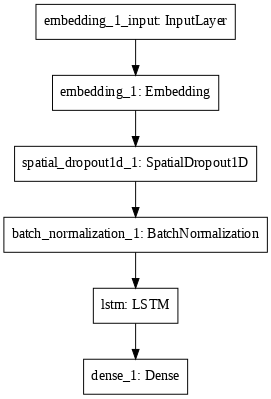

In [ ]:
model_LSTM_1 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_1.add(Embedding(maxWordsCount, 5, input_length=xLen))

model_LSTM_1.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_LSTM_1.add(LSTM(4))
model_LSTM_1.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_1.summary()
print()
plot_model(model_LSTM_1, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_1.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/100
35/35 [==============================] - 9s 93ms/step - loss: 1.7805 - accuracy: 0.1918 - val_loss: 1.7671 - val_accuracy: 0.2927
Epoch 2/100
35/35 [==============================] - 3s 76ms/step - loss: 1.7188 - accuracy: 0.3369 - val_loss: 1.7489 - val_accuracy: 0.2928
Epoch 3/100
35/35 [==============================] - 3s 77ms/step - loss: 1.6702 - accuracy: 0.3554 - val_loss: 1.7420 - val_accuracy: 0.2928
Epoch 4/100
35/35 [==============================] - 3s 77ms/step - loss: 1.6160 - accuracy: 0.3786 - val_loss: 1.7438 - val_accuracy: 0.2928
Epoch 5/100
35/35 [==============================] - 3s 76ms/step - loss: 1.5624 - accuracy: 0.4019 - val_loss: 1.7531 - val_accuracy: 0.2925
Epoch 6/100
35/35 [==============================] - 3s 77ms/step - loss: 1.4985 - accuracy: 0.4337 - val_loss: 1.7808 - val_accuracy: 0.2241
Epoch 7/100
35/35 [==============================] - 3s 76ms/step - loss: 1.4292 - accuracy: 0.4627 - val_loss: 1.8340 - val_accuracy: 0.0917
Epoch 

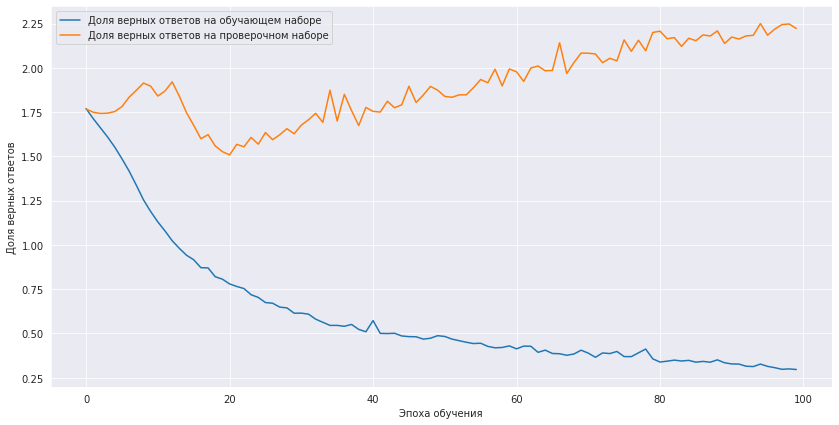

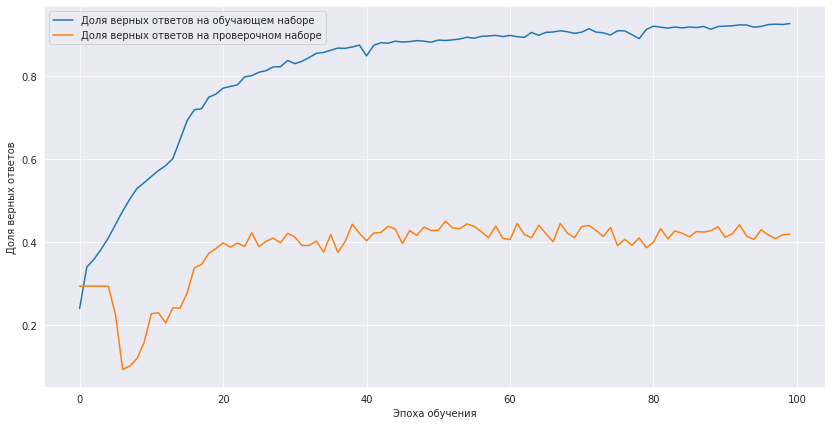

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_LSTM_1, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  22 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  31 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  29 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  35 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  63 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  39 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  41 %



####**Иссл. №9**

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 5)           20        
_________________________________________________________________
lstm (LSTM)                  (None, 20)                2080      
_________________________________________________________________
dense (Dense)                (None, 6)                 126       
Total params: 102,226
Trainable params: 102,216
Non-trainable params: 10
_________________________________________________________________



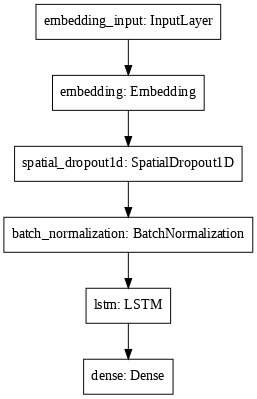

In [ ]:
model_LSTM_2 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_2.add(Embedding(maxWordsCount, 5, input_length=xLen))

model_LSTM_2.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_LSTM_2.add(LSTM(20))
model_LSTM_2.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_2.summary()
print()
plot_model(model_LSTM_2, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_2.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/100
35/35 [==============================] - 12s 110ms/step - loss: 1.7482 - accuracy: 0.2313 - val_loss: 2.0580 - val_accuracy: 0.2928
Epoch 2/100
35/35 [==============================] - 3s 88ms/step - loss: 1.4160 - accuracy: 0.4342 - val_loss: 1.8710 - val_accuracy: 0.1972
Epoch 3/100
35/35 [==============================] - 3s 88ms/step - loss: 1.2742 - accuracy: 0.4713 - val_loss: 1.9525 - val_accuracy: 0.1972
Epoch 4/100
35/35 [==============================] - 3s 87ms/step - loss: 1.1969 - accuracy: 0.4785 - val_loss: 2.0579 - val_accuracy: 0.1972
Epoch 5/100
35/35 [==============================] - 3s 86ms/step - loss: 1.1931 - accuracy: 0.4754 - val_loss: 2.0750 - val_accuracy: 0.2081
Epoch 6/100
35/35 [==============================] - 3s 87ms/step - loss: 1.0789 - accuracy: 0.5067 - val_loss: 1.9058 - val_accuracy: 0.2038
Epoch 7/100
35/35 [==============================] - 3s 88ms/step - loss: 0.9961 - accuracy: 0.6219 - val_loss: 2.0177 - val_accuracy: 0.2075
Epoc

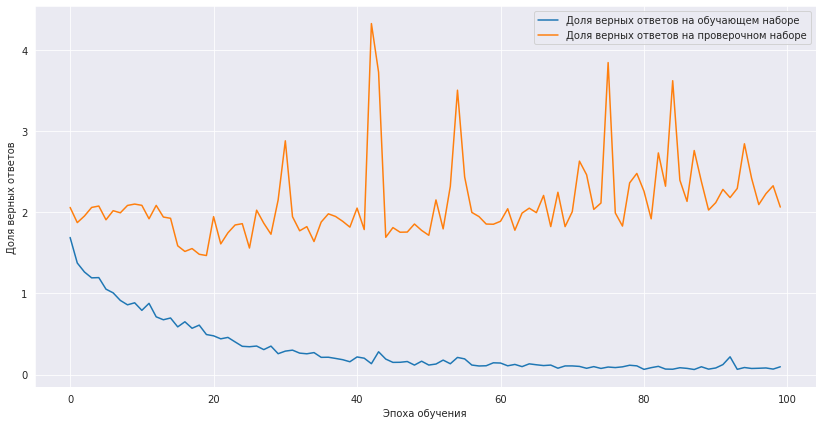

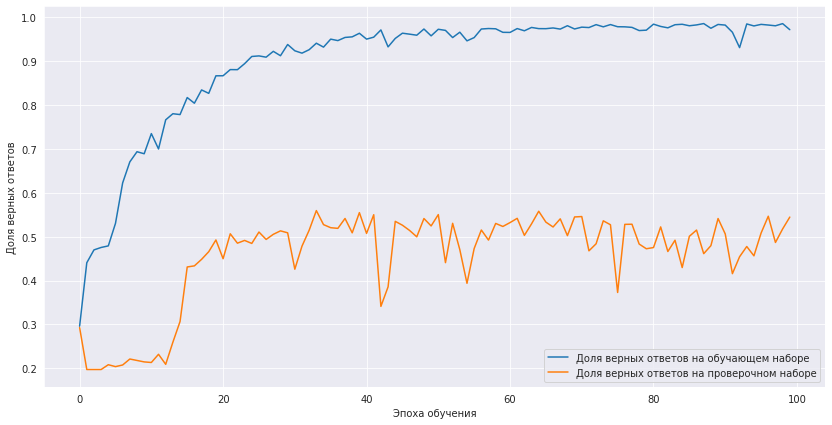

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_LSTM_2, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  25 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  72 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  58 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  34 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  59 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  47 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  54 %



####**Иссл. №10**

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1000, 5)           20        
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 606       
Total params: 143,026
Trainable params: 143,016
Non-trainable params: 10
_________________________________________________________________



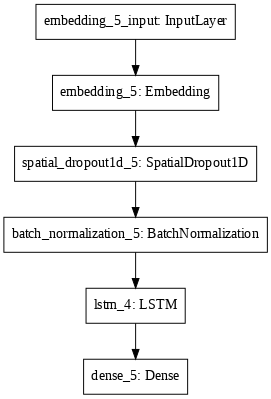

In [ ]:
model_LSTM_3 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_3.add(Embedding(maxWordsCount, 5, input_length=xLen))

model_LSTM_3.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_LSTM_3.add(LSTM(100))
model_LSTM_3.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_3.summary()
print()
plot_model(model_LSTM_3, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_3.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/100
35/35 [==============================] - 7s 144ms/step - loss: 1.6632 - accuracy: 0.3511 - val_loss: 1.7604 - val_accuracy: 0.2407
Epoch 2/100
35/35 [==============================] - 5s 133ms/step - loss: 1.2904 - accuracy: 0.4685 - val_loss: 2.1373 - val_accuracy: 0.1611
Epoch 3/100
35/35 [==============================] - 5s 133ms/step - loss: 1.2098 - accuracy: 0.4833 - val_loss: 2.1354 - val_accuracy: 0.1672
Epoch 4/100
35/35 [==============================] - 5s 135ms/step - loss: 1.2910 - accuracy: 0.5176 - val_loss: 2.1534 - val_accuracy: 0.2192
Epoch 5/100
35/35 [==============================] - 5s 134ms/step - loss: 0.9763 - accuracy: 0.5998 - val_loss: 2.0668 - val_accuracy: 0.1744
Epoch 6/100
35/35 [==============================] - 5s 133ms/step - loss: 0.8578 - accuracy: 0.6506 - val_loss: 2.0564 - val_accuracy: 0.1996
Epoch 7/100
35/35 [==============================] - 5s 133ms/step - loss: 0.8959 - accuracy: 0.6674 - val_loss: 2.1067 - val_accuracy: 0.1971

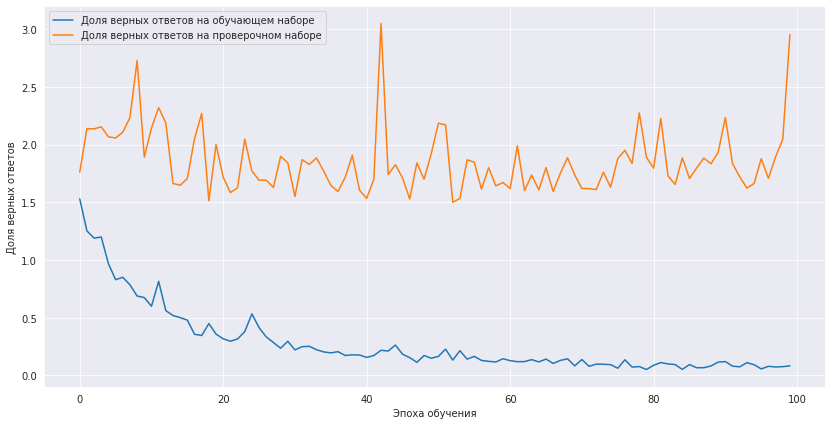

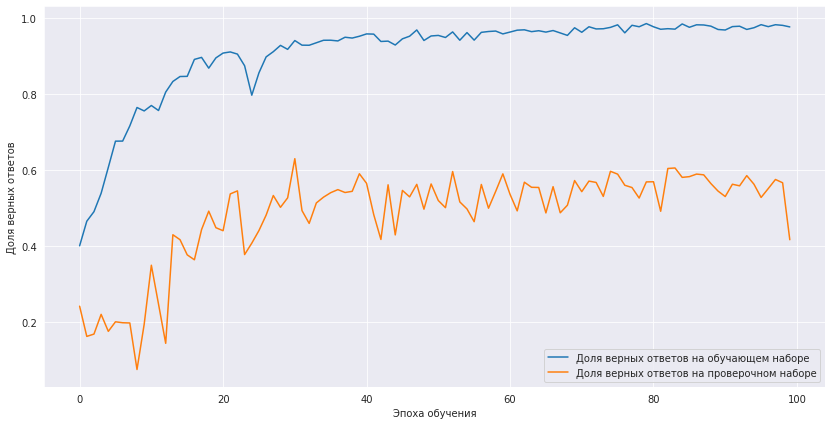

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_LSTM_3, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  25 % сеть считает, что это  Саймак ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  33 % сеть считает, что это  Саймак ,  распознано НЕ ВЕРНО!
Булгаков  распознано  5 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Саймак  распознано  93 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  72 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  25 % сеть считает, что это  Саймак ,  распознано НЕ ВЕРНО!

Средний процент распознавания  41 %



####**Иссл. №11**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 5)           100000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1000, 5)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 5)           20        
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 4)           160       
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 30        
Total params: 100,354
Trainable params: 100,344
Non-trainable params: 10
_______________________________________________

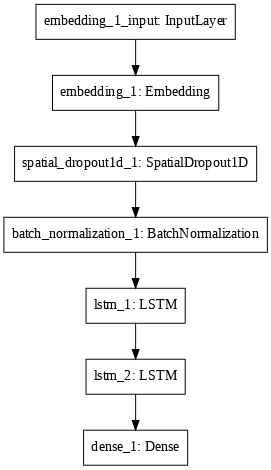

In [ ]:
model_LSTM_4 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_4.add(Embedding(maxWordsCount, 5, input_length=xLen))

model_LSTM_4.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_4.add(BatchNormalization())  # добавляем слой нормализации данных
model_LSTM_4.add(LSTM(4, return_sequences=True))
model_LSTM_4.add(LSTM(4))
model_LSTM_4.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_4.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_4.summary()
print()
plot_model(model_LSTM_4, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_4.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/100
35/35 [==============================] - 10s 170ms/step - loss: 1.7491 - accuracy: 0.3070 - val_loss: 1.8329 - val_accuracy: 0.1525
Epoch 2/100
35/35 [==============================] - 5s 147ms/step - loss: 1.5893 - accuracy: 0.4326 - val_loss: 1.9813 - val_accuracy: 0.0738
Epoch 3/100
35/35 [==============================] - 5s 148ms/step - loss: 1.4452 - accuracy: 0.4662 - val_loss: 2.0568 - val_accuracy: 0.0738
Epoch 4/100
35/35 [==============================] - 5s 147ms/step - loss: 1.3875 - accuracy: 0.4465 - val_loss: 2.1343 - val_accuracy: 0.0913
Epoch 5/100
35/35 [==============================] - 5s 147ms/step - loss: 1.3694 - accuracy: 0.4193 - val_loss: 2.1506 - val_accuracy: 0.1785
Epoch 6/100
35/35 [==============================] - 5s 146ms/step - loss: 1.2705 - accuracy: 0.4488 - val_loss: 2.1409 - val_accuracy: 0.2190
Epoch 7/100
35/35 [==============================] - 5s 147ms/step - loss: 1.1703 - accuracy: 0.4731 - val_loss: 1.9758 - val_accuracy: 0.295

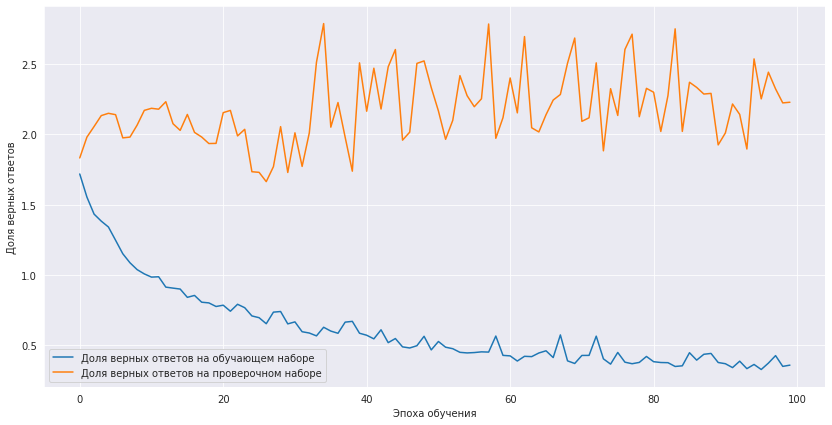

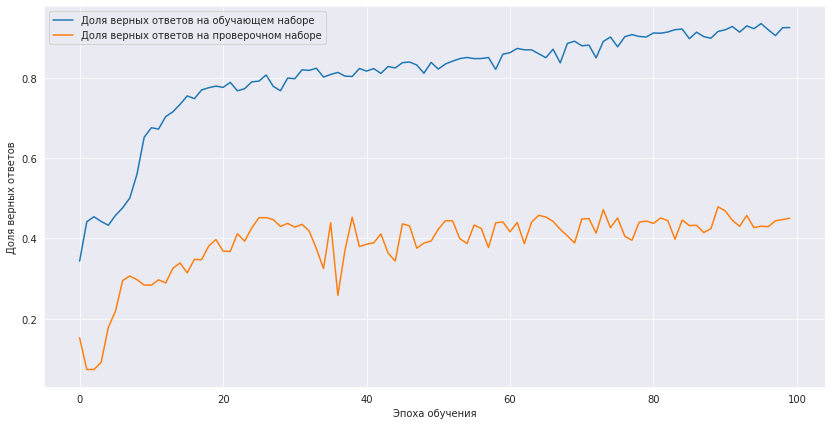

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_LSTM_4, xTest6Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  41 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  57 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  22 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Саймак  распознано  44 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  66 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  27 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  45 %



####**Иссл. №12**

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 200)         4000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 1000, 200)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 200)         800       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1000, 4)           3280      
_________________________________________________________________
lstm_4 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 30        
Total params: 4,004,254
Trainable params: 4,003,854
Non-trainable params: 400
__________________________________________

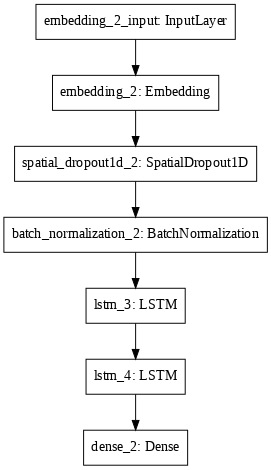

In [ ]:
model_LSTM_5 = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_5.add(Embedding(maxWordsCount, 200, input_length=xLen))

model_LSTM_5.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_5.add(BatchNormalization())  # добавляем слой нормализации данных
model_LSTM_5.add(LSTM(4, return_sequences=True))
model_LSTM_5.add(LSTM(4))
model_LSTM_5.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_5.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_5.summary()
print()
plot_model(model_LSTM_5, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_5.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/100
35/35 [==============================] - 20s 450ms/step - loss: 1.7275 - accuracy: 0.3014 - val_loss: 1.8137 - val_accuracy: 0.1023
Epoch 2/100
35/35 [==============================] - 15s 424ms/step - loss: 1.4834 - accuracy: 0.4383 - val_loss: 2.0117 - val_accuracy: 0.0738
Epoch 3/100
35/35 [==============================] - 15s 418ms/step - loss: 1.3081 - accuracy: 0.5027 - val_loss: 2.1471 - val_accuracy: 0.0738
Epoch 4/100
35/35 [==============================] - 15s 422ms/step - loss: 1.1818 - accuracy: 0.6010 - val_loss: 2.2324 - val_accuracy: 0.0738
Epoch 5/100
35/35 [==============================] - 15s 418ms/step - loss: 1.0643 - accuracy: 0.6935 - val_loss: 2.3132 - val_accuracy: 0.0738
Epoch 6/100
35/35 [==============================] - 15s 420ms/step - loss: 0.9622 - accuracy: 0.7356 - val_loss: 2.3908 - val_accuracy: 0.0738
Epoch 7/100
35/35 [==============================] - 14s 410ms/step - loss: 0.8826 - accuracy: 0.7655 - val_loss: 2.4321 - val_accuracy:

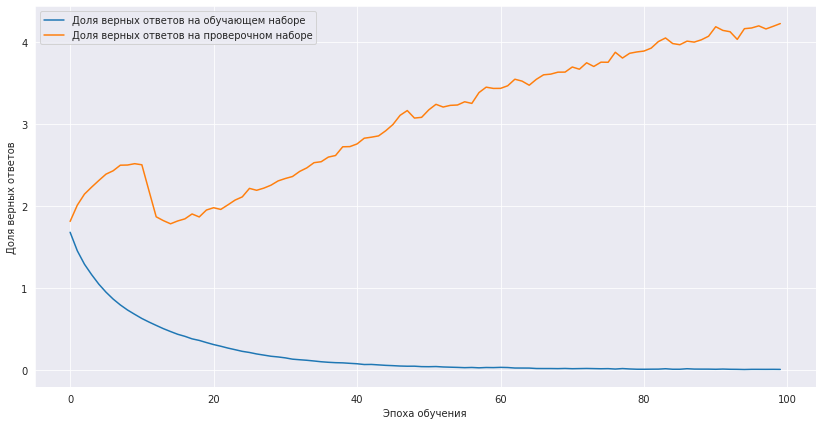

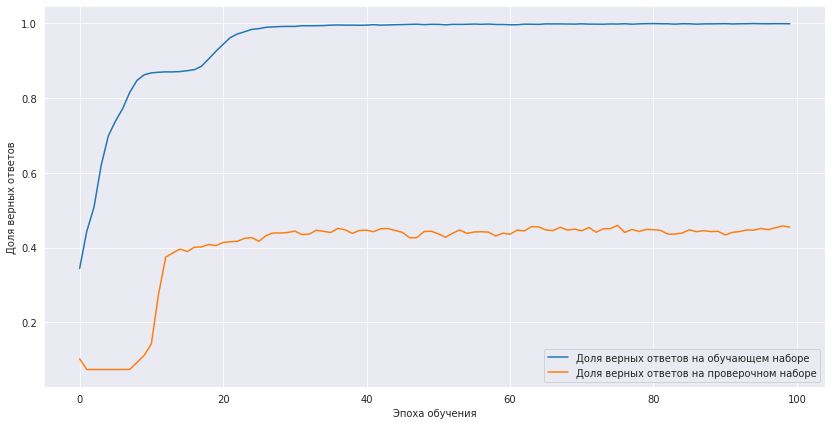

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_LSTM_5, xTest6Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  48 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  26 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  29 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  17 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Фрай  распознано  72 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  46 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  45 %



####**Иссл. №13**

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 50)          1000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 1000, 50)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1000, 50)          200       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000, 16)          3776      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 16)                1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                

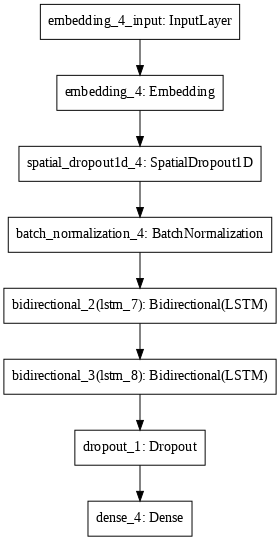

In [ ]:
model_LSTM_6 = Sequential() # создаём последовательную модель нейросети
model_LSTM_6 = Sequential() #создаём последовательную модель нейросети

#преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_6.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_LSTM_6.add(SpatialDropout1D(0.4)) #добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_6.add(BatchNormalization()) #добавляем слой нормализации данных
model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True))) #добавляем слой с двунаправленным LSTM, совместимый с Cuda при поддержке GPU
model_LSTM_6.add(Bidirectional(LSTM(8, return_sequences=True))) #добавляем слой с двунаправленным LSTM, совместимый с Cuda при поддержке GPU
model_LSTM_6.add(Dropout(0.3)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_6.add(BatchNormalization()) #добавляем слой нормализации данных
model_LSTM_6.add(GRU(16, return_sequences=True, reset_after=True)) #добавляем слой GRU, совместимый с Cuda при поддержке GPU
model_LSTM_6.add(GRU(16, reset_after=True)) #добавляем слой GRU, совместимый с Cuda при поддержке GPU
model_LSTM_6.add(Dropout(0.3)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_6.add(BatchNormalization()) #добавляем слой нормализации данных
model_LSTM_6.add(Dense(200, activation='relu')) #добавляем полносвязный слой с указанием количества нейронов и функции активации
model_LSTM_6.add(Dropout(0.3)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_6.add(BatchNormalization()) #добавляем слой нормализации данных
model_LSTM_6.add(Dense(6, activation='softmax')) #добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое


# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_6.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_6.summary()
print()
plot_model(model_LSTM_6, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_6.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/100
35/35 [==============================] - 21s 415ms/step - loss: 1.7199 - accuracy: 0.2683 - val_loss: 1.7308 - val_accuracy: 0.2928
Epoch 2/100
35/35 [==============================] - 13s 370ms/step - loss: 1.4298 - accuracy: 0.4516 - val_loss: 1.7384 - val_accuracy: 0.3108
Epoch 3/100
35/35 [==============================] - 13s 362ms/step - loss: 1.1817 - accuracy: 0.5675 - val_loss: 1.7652 - val_accuracy: 0.3315
Epoch 4/100
35/35 [==============================] - 13s 364ms/step - loss: 0.9812 - accuracy: 0.6712 - val_loss: 2.2073 - val_accuracy: 0.1824
Epoch 5/100
35/35 [==============================] - 13s 364ms/step - loss: 0.8101 - accuracy: 0.7444 - val_loss: 2.2170 - val_accuracy: 0.2129
Epoch 6/100
35/35 [==============================] - 13s 365ms/step - loss: 0.6881 - accuracy: 0.8003 - val_loss: 2.3602 - val_accuracy: 0.2456
Epoch 7/100
35/35 [==============================] - 13s 365ms/step - loss: 0.5601 - accuracy: 0.8471 - val_loss: 2.5217 - val_accuracy:

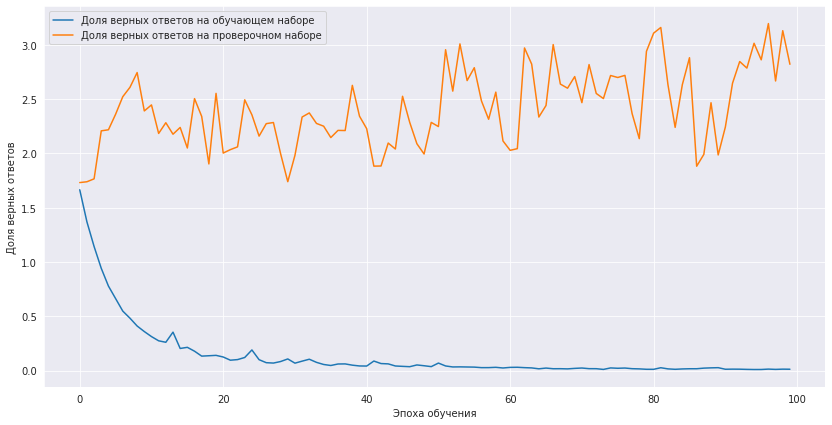

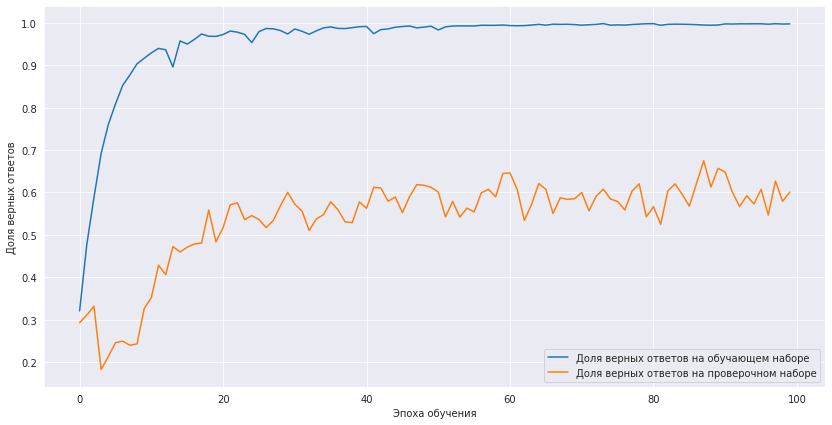

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_LSTM_6, xTest6Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  63 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  57 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  19 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Саймак  распознано  63 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  89 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  56 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  60 %



####**Иссл. №14**

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 50)          1000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 1000, 50)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 1000, 50)          200       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000, 16)          3776      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 16)                1600      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                

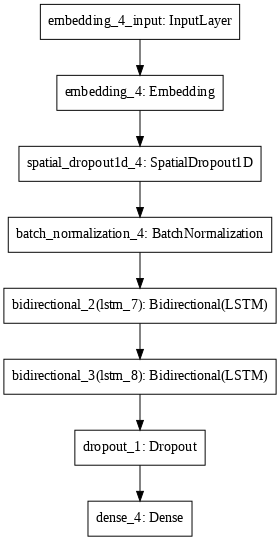

In [ ]:
model_LSTM_7 = Sequential() #создаём последовательную модель нейросети

#преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_7.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_LSTM_7.add(SpatialDropout1D(0.4)) #добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_7.add(BatchNormalization()) #добавляем слой нормализации данных
model_LSTM_7.add(Bidirectional(LSTM(8, return_sequences=True))) #добавляем слой с двунаправленным LSTM, совместимый с Cuda при поддержке GPU
model_LSTM_7.add(Bidirectional(LSTM(8))) #добавляем слой с двунаправленным LSTM, совместимый с Cuda при поддержке GPU
model_LSTM_7.add(Dropout(0.3)) #добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_7.add(Dense(6, activation='softmax')) #добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое


# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_7.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_7.summary()
print()
plot_model(model_LSTM_7, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_7.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=512,
                    validation_data=(xTest, yTest))

Epoch 1/100
35/35 [==============================] - 30s 561ms/step - loss: 2.1262 - accuracy: 0.2104 - val_loss: 1.7465 - val_accuracy: 0.2928
Epoch 2/100
35/35 [==============================] - 18s 505ms/step - loss: 1.6859 - accuracy: 0.3561 - val_loss: 1.7685 - val_accuracy: 0.1611
Epoch 3/100
35/35 [==============================] - 18s 505ms/step - loss: 1.3456 - accuracy: 0.4622 - val_loss: 1.8251 - val_accuracy: 0.1724
Epoch 4/100
35/35 [==============================] - 18s 504ms/step - loss: 1.1634 - accuracy: 0.5323 - val_loss: 2.0955 - val_accuracy: 0.3020
Epoch 5/100
35/35 [==============================] - 18s 506ms/step - loss: 1.0874 - accuracy: 0.5802 - val_loss: 1.7750 - val_accuracy: 0.2743
Epoch 6/100
35/35 [==============================] - 18s 505ms/step - loss: 0.8912 - accuracy: 0.6438 - val_loss: 2.2645 - val_accuracy: 0.3191
Epoch 7/100
35/35 [==============================] - 18s 507ms/step - loss: 0.7405 - accuracy: 0.6952 - val_loss: 3.2633 - val_accuracy:

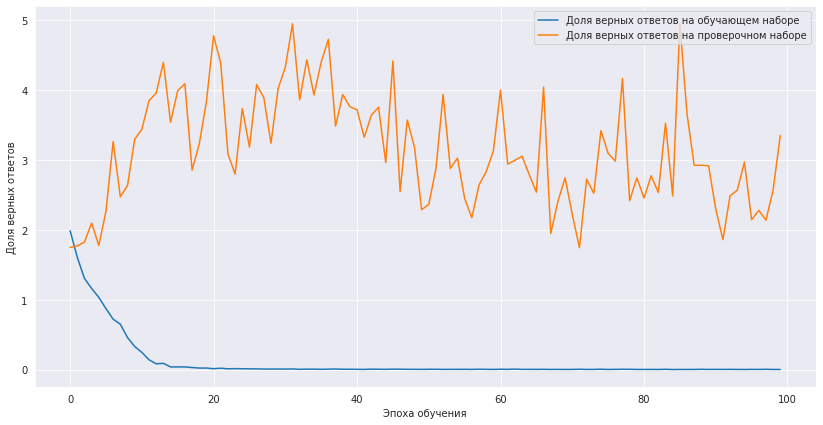

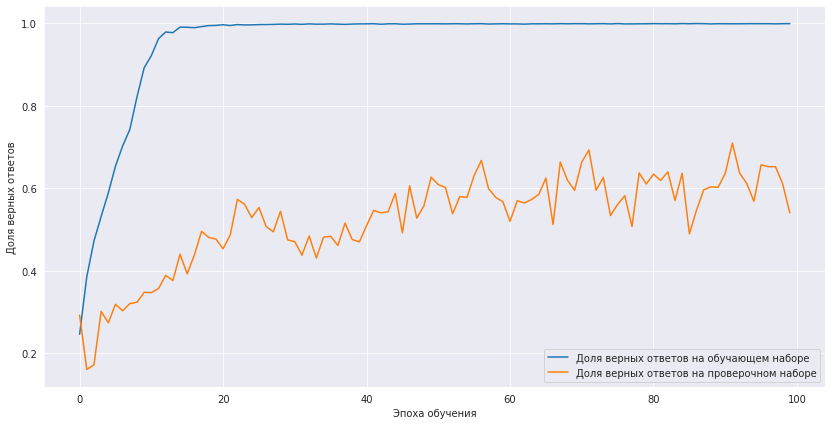

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_LSTM_7, xTest6Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  85 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  47 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  10 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Саймак  распознано  32 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Фрай  распознано  91 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  42 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  54 %



####**Иссл. №15**

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 1000, 10)          0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 1000, 10)          40        
_________________________________________________________________
lstm_12 (LSTM)               (None, 4)                 240       
_________________________________________________________________
dropout_7 (Dropout)          (None, 4)                 0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 4)                 16        
_________________________________________________________________
dense_9 (Dense)              (None, 100)              

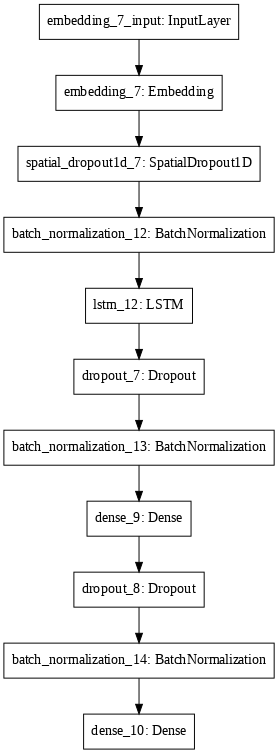

In [ ]:
model_LSTM_8 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_8.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_LSTM_8.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_8.add(BatchNormalization())  # добавляем слой нормализации данных
model_LSTM_8.add(LSTM(4)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LSTM_8.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_8.add(BatchNormalization()) # добавляем слой нормализации данных
model_LSTM_8.add(Dense(100, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_LSTM_8.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_8.add(BatchNormalization()) # добавляем слой нормализации данных
model_LSTM_8.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_8.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_8.summary()
print()
plot_model(model_LSTM_8, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_8.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=200,
                    validation_data=(xTest, yTest))


Epoch 1/100
89/89 [==============================] - 10s 80ms/step - loss: 2.1204 - accuracy: 0.2050 - val_loss: 1.7442 - val_accuracy: 0.2928
Epoch 2/100
89/89 [==============================] - 6s 68ms/step - loss: 1.9104 - accuracy: 0.2611 - val_loss: 1.7476 - val_accuracy: 0.2928
Epoch 3/100
89/89 [==============================] - 6s 69ms/step - loss: 1.8114 - accuracy: 0.2881 - val_loss: 1.7401 - val_accuracy: 0.2928
Epoch 4/100
89/89 [==============================] - 6s 68ms/step - loss: 1.7621 - accuracy: 0.2966 - val_loss: 1.7293 - val_accuracy: 0.2928
Epoch 5/100
89/89 [==============================] - 6s 69ms/step - loss: 1.7163 - accuracy: 0.3202 - val_loss: 1.7115 - val_accuracy: 0.2949
Epoch 6/100
89/89 [==============================] - 6s 68ms/step - loss: 1.6554 - accuracy: 0.3481 - val_loss: 1.7715 - val_accuracy: 0.3150
Epoch 7/100
89/89 [==============================] - 6s 69ms/step - loss: 1.5351 - accuracy: 0.4116 - val_loss: 1.6334 - val_accuracy: 0.4027
Epoch

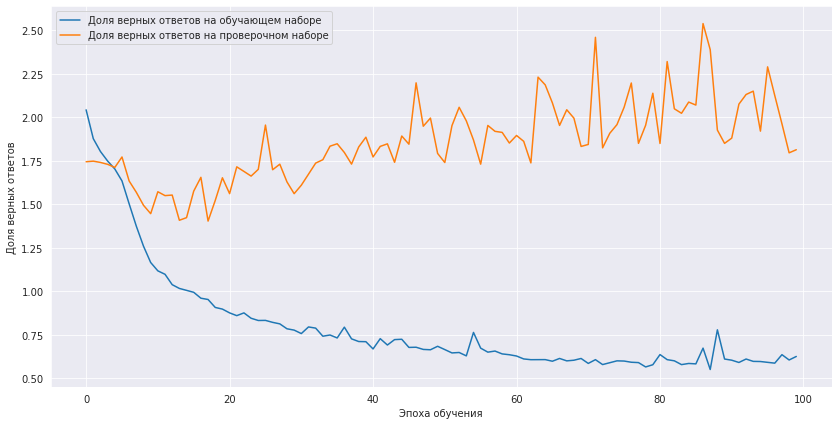

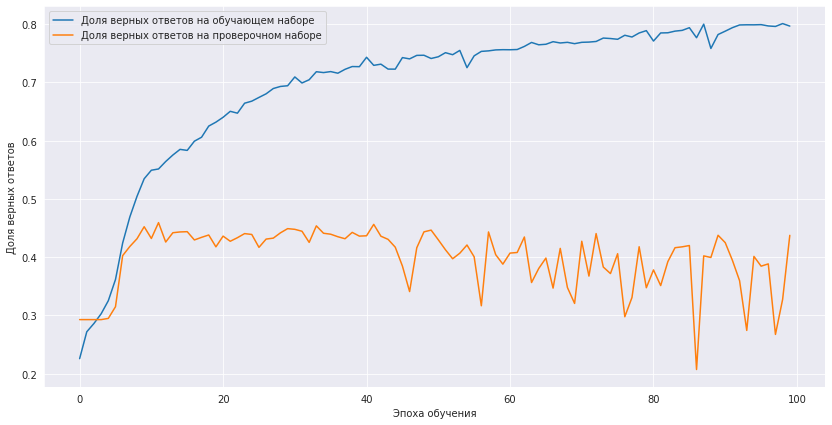

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_LSTM_8, xTest6Classes, "Embedding + LSTM") # функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  1 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  14 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Булгаков  распознано  0 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Саймак  распознано  45 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Фрай  распознано  67 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  91 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  43 %



####**Иссл. №16**

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 1000, 10)          0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 1000, 10)          40        
_________________________________________________________________
lstm_14 (LSTM)               (None, 1000, 4)           240       
_________________________________________________________________
dropout_11 (Dropout)         (None, 1000, 4)           0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 1000, 4)           16        
_________________________________________________________________
dense_13 (Dense)             (None, 1000, 100)       

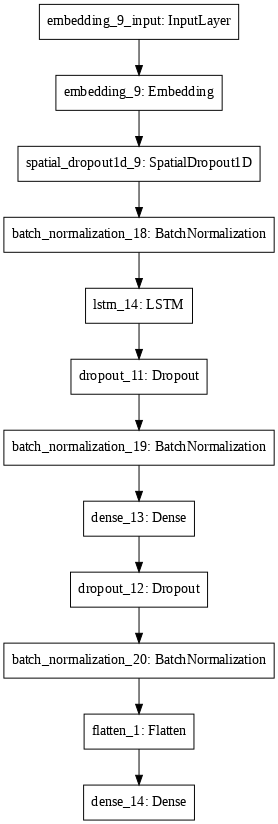

In [ ]:
model_LSTM_9 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LSTM_9.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_LSTM_9.add(SpatialDropout1D(0.4)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LSTM_9.add(BatchNormalization())  # добавляем слой нормализации данных
model_LSTM_9.add(LSTM(4, return_sequences=True)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LSTM_9.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_9.add(BatchNormalization()) # добавляем слой нормализации данных
model_LSTM_9.add(Dense(100, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_LSTM_9.add(Dropout(0.5)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LSTM_9.add(BatchNormalization()) # добавляем слой нормализации данных
model_LSTM_9.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_LSTM_9.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LSTM_9.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LSTM_9.summary()
print()
plot_model(model_LSTM_9, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LSTM_9.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=200,
                    validation_data=(xTest, yTest))


Epoch 1/100
89/89 [==============================] - 11s 87ms/step - loss: 3.0221 - accuracy: 0.3994 - val_loss: 3.2152 - val_accuracy: 0.4161
Epoch 2/100
89/89 [==============================] - 7s 81ms/step - loss: 0.7568 - accuracy: 0.8448 - val_loss: 5.7730 - val_accuracy: 0.0898
Epoch 3/100
89/89 [==============================] - 7s 81ms/step - loss: 0.3827 - accuracy: 0.9331 - val_loss: 5.0851 - val_accuracy: 0.1802
Epoch 4/100
89/89 [==============================] - 7s 80ms/step - loss: 0.2686 - accuracy: 0.9580 - val_loss: 14.7051 - val_accuracy: 0.1977
Epoch 5/100
89/89 [==============================] - 7s 82ms/step - loss: 0.2748 - accuracy: 0.9639 - val_loss: 9.8605 - val_accuracy: 0.2565
Epoch 6/100
89/89 [==============================] - 7s 83ms/step - loss: 0.2703 - accuracy: 0.9675 - val_loss: 6.2012 - val_accuracy: 0.5800
Epoch 7/100
89/89 [==============================] - 7s 83ms/step - loss: 0.2247 - accuracy: 0.9729 - val_loss: 4.4974 - val_accuracy: 0.6673
Epoc

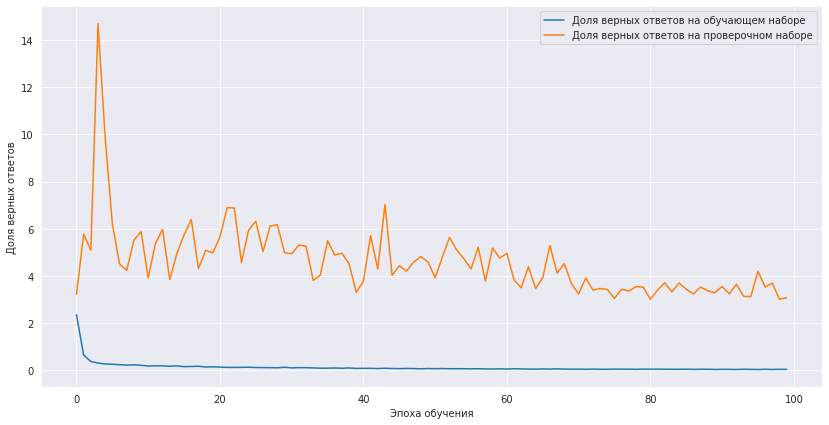

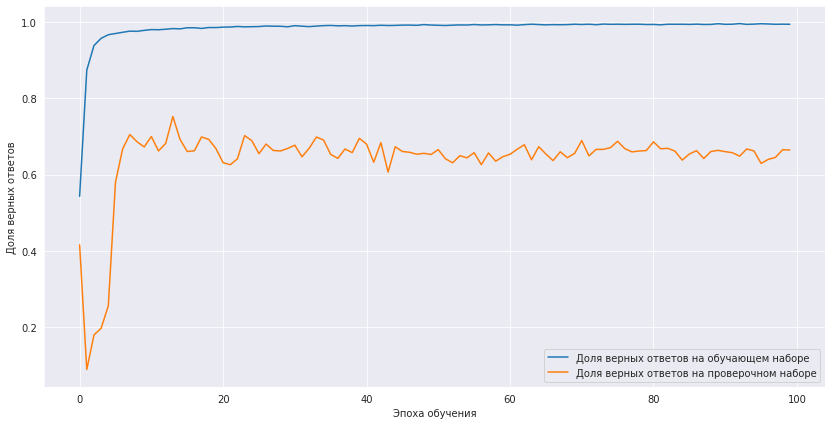

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_LSTM_9, xTest6Classes, "Embedding + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + LSTM

О. Генри  распознано  26 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  79 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  67 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  44 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  76 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  63 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  66 %



### Conv1D

####**Иссл. №17**

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 1000, 10)          0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 1000, 10)          40        
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 20)          1020      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 20)           2020      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 498, 20)           0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 498, 20)         

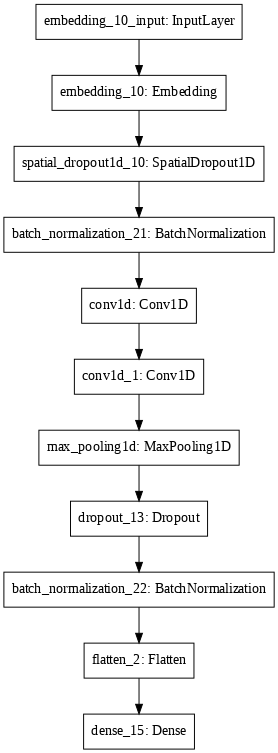

In [ ]:
model_Conv_1 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Conv_1.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_Conv_1.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Conv_1.add(BatchNormalization())  # добавляем слой нормализации данных
model_Conv_1.add(Conv1D(20, 5, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_1.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Conv_1.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_1.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_Conv_1.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Conv_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Conv_1.summary()
print()
plot_model(model_Conv_1, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Conv_1.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=200,
                    validation_data=(xTest, yTest))

Epoch 1/100
89/89 [==============================] - 4s 23ms/step - loss: 1.7109 - accuracy: 0.4118 - val_loss: 2.8912 - val_accuracy: 0.2928
Epoch 2/100
89/89 [==============================] - 2s 20ms/step - loss: 0.0685 - accuracy: 0.9793 - val_loss: 6.4720 - val_accuracy: 0.2928
Epoch 3/100
89/89 [==============================] - 2s 24ms/step - loss: 0.0199 - accuracy: 0.9926 - val_loss: 9.7841 - val_accuracy: 0.2928
Epoch 4/100
89/89 [==============================] - 2s 20ms/step - loss: 0.0126 - accuracy: 0.9963 - val_loss: 5.4131 - val_accuracy: 0.2990
Epoch 5/100
89/89 [==============================] - 2s 20ms/step - loss: 0.0090 - accuracy: 0.9967 - val_loss: 4.7009 - val_accuracy: 0.3054
Epoch 6/100
89/89 [==============================] - 2s 20ms/step - loss: 0.0070 - accuracy: 0.9978 - val_loss: 2.7569 - val_accuracy: 0.4442
Epoch 7/100
89/89 [==============================] - 2s 20ms/step - loss: 0.0095 - accuracy: 0.9971 - val_loss: 2.6543 - val_accuracy: 0.5350
Epoch 

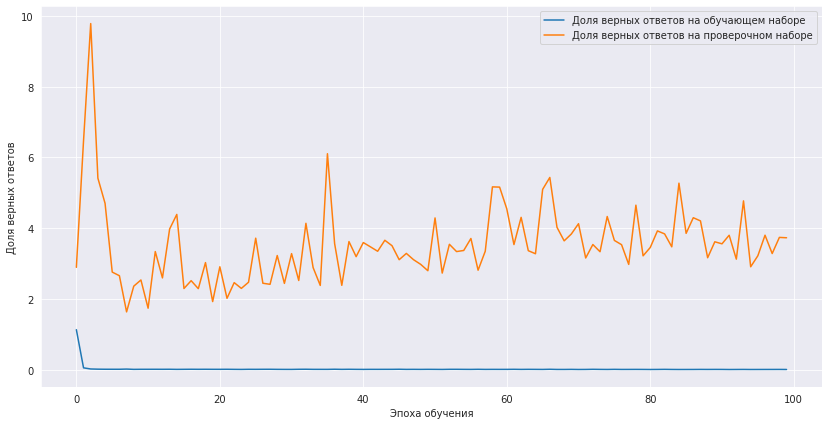

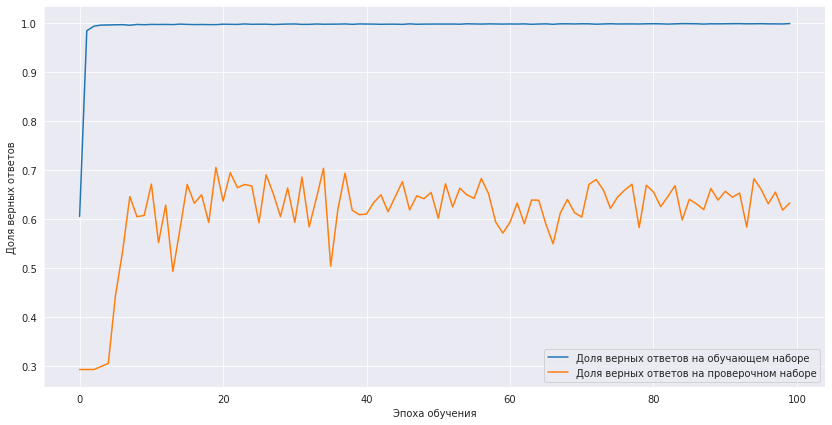

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_Conv_1, xTest6Classes, "Embedding + Conv") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv

О. Генри  распознано  24 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  46 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  77 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  40 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  89 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  48 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  63 %



####**Иссл. №18**

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 1000, 50)          1000000   
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 1000, 50)          0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 1000, 50)          200       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 20)          5020      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 20)          2020      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 20)           0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 500, 20)         

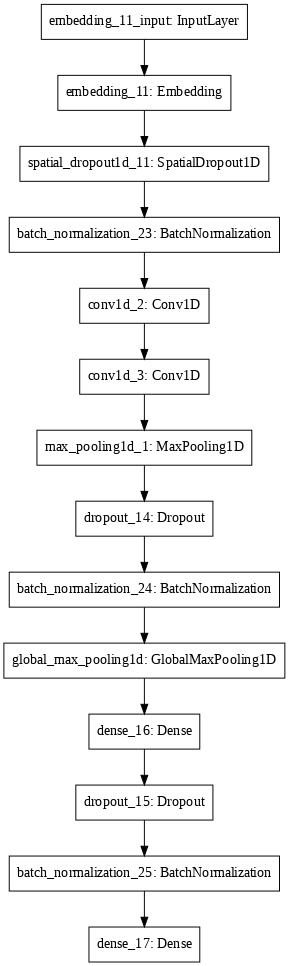

In [ ]:
model_Conv_2 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Conv_2.add(Embedding(maxWordsCount, 50, input_length=xLen))

model_Conv_2.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Conv_2.add(BatchNormalization())  # добавляем слой нормализации данных
model_Conv_2.add(Conv1D(20, 5, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_2.add(Conv1D(20, 5, activation="relu", padding='same')) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_2.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Conv_2.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_2.add(GlobalMaxPooling1D()) # добавляем слой подвыборки/пулинга с функцией максимума(по всей длине входящей последовательности)
model_Conv_2.add(Dense(20, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_Conv_2.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_2.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Conv_2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model_Conv_2.summary()
print()
plot_model(model_Conv_2, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Conv_2.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=200,
                    validation_data=(xTest, yTest))

Epoch 1/100
89/89 [==============================] - 6s 50ms/step - loss: 1.6229 - accuracy: 0.3538 - val_loss: 1.8292 - val_accuracy: 0.1969
Epoch 2/100
89/89 [==============================] - 4s 45ms/step - loss: 0.5771 - accuracy: 0.8689 - val_loss: 1.9767 - val_accuracy: 0.1989
Epoch 3/100
89/89 [==============================] - 4s 45ms/step - loss: 0.2671 - accuracy: 0.9640 - val_loss: 1.8383 - val_accuracy: 0.3215
Epoch 4/100
89/89 [==============================] - 4s 45ms/step - loss: 0.1398 - accuracy: 0.9793 - val_loss: 1.8815 - val_accuracy: 0.2972
Epoch 5/100
89/89 [==============================] - 4s 45ms/step - loss: 0.0808 - accuracy: 0.9884 - val_loss: 1.7162 - val_accuracy: 0.3889
Epoch 6/100
89/89 [==============================] - 4s 45ms/step - loss: 0.0547 - accuracy: 0.9908 - val_loss: 1.4930 - val_accuracy: 0.4515
Epoch 7/100
89/89 [==============================] - 4s 45ms/step - loss: 0.0465 - accuracy: 0.9909 - val_loss: 1.5044 - val_accuracy: 0.4714
Epoch 

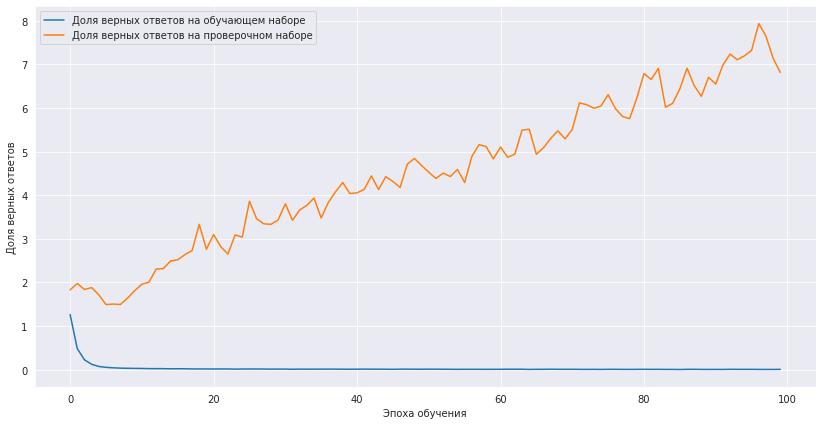

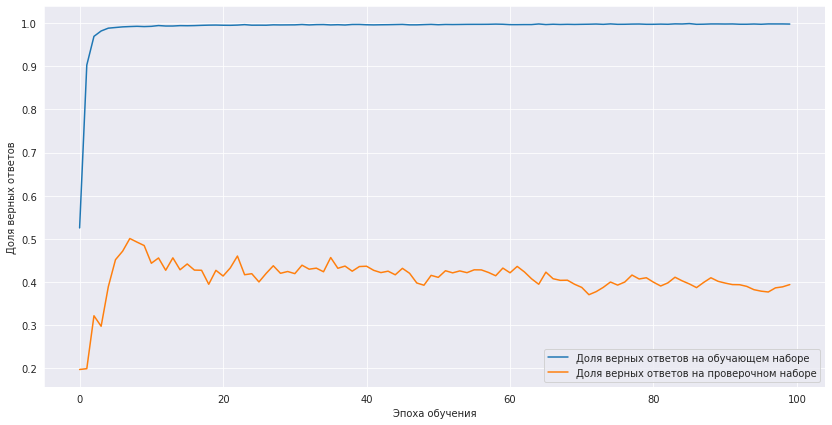

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_Conv_2, xTest6Classes, "Embedding + Conv") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv

О. Генри  распознано  91 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  9 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  30 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  11 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Фрай  распознано  75 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  8 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!

Средний процент распознавания  39 %



####**Иссл. №19**

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d_12 (Spatia (None, 1000, 10)          0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 1000, 10)          40        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 996, 20)           1020      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 992, 20)           2020      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 496, 20)           0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 496, 20)         

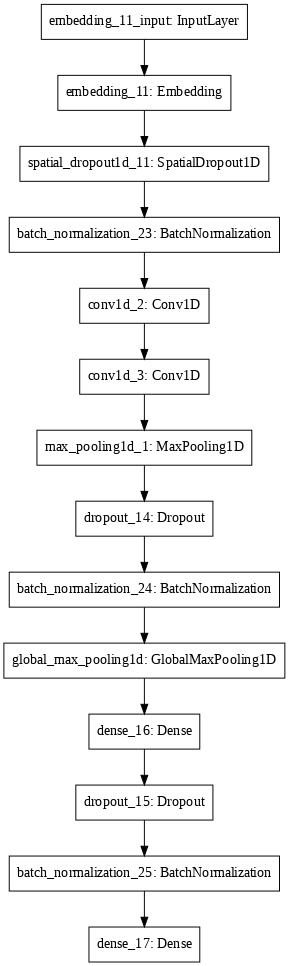

In [ ]:
model_Conv_3 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Conv_3.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_Conv_3.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Conv_3.add(BatchNormalization())  # добавляем слой нормализации данных
model_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_3.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Conv_3.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_3.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Conv_3.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_3.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Conv_3.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_3.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_Conv_3.add(Dense(64, activation='relu')) # добавляем полносвязный слой на 64 нейрона, с функцией активации relu
model_Conv_3.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Conv_3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Conv_3.summary()
print()
plot_model(model_Conv_2, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Conv_3.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=200,
                    validation_data=(xTest, yTest))

Epoch 1/100
89/89 [==============================] - 6s 30ms/step - loss: 1.9750 - accuracy: 0.2828 - val_loss: 2.0006 - val_accuracy: 0.1611
Epoch 2/100
89/89 [==============================] - 2s 25ms/step - loss: 0.8833 - accuracy: 0.6309 - val_loss: 2.8494 - val_accuracy: 0.3049
Epoch 3/100
89/89 [==============================] - 2s 24ms/step - loss: 0.3064 - accuracy: 0.8823 - val_loss: 9.1349 - val_accuracy: 0.2928
Epoch 4/100
89/89 [==============================] - 2s 24ms/step - loss: 0.0992 - accuracy: 0.9663 - val_loss: 31.1901 - val_accuracy: 0.2928
Epoch 5/100
89/89 [==============================] - 2s 25ms/step - loss: 0.0491 - accuracy: 0.9836 - val_loss: 22.6524 - val_accuracy: 0.2930
Epoch 6/100
89/89 [==============================] - 2s 24ms/step - loss: 0.0465 - accuracy: 0.9868 - val_loss: 20.3692 - val_accuracy: 0.2954
Epoch 7/100
89/89 [==============================] - 2s 24ms/step - loss: 0.0222 - accuracy: 0.9929 - val_loss: 6.7392 - val_accuracy: 0.3655
Epo

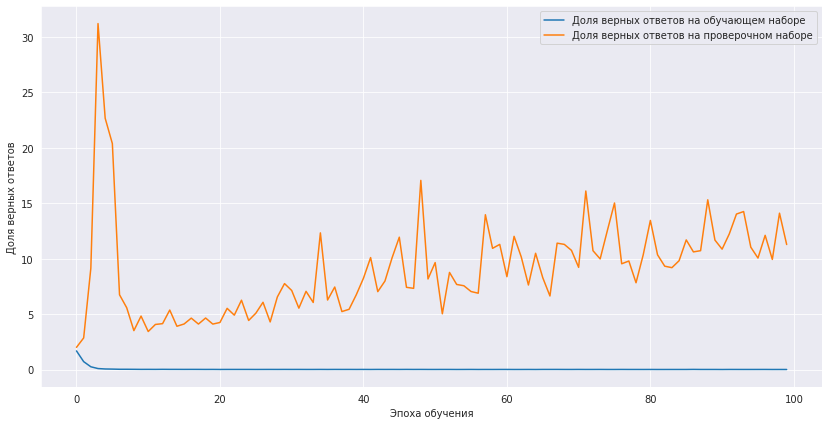

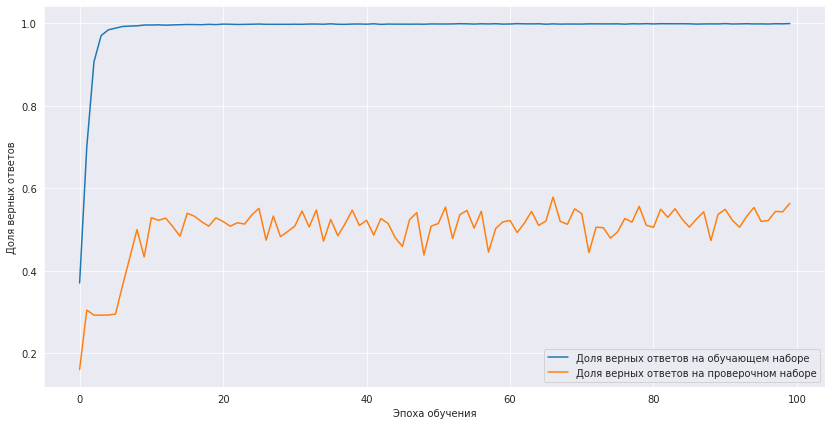

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_Conv_3, xTest6Classes, "Embedding + Conv") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv

О. Генри  распознано  6 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  5 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  93 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  23 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!
Фрай  распознано  80 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  56 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  56 %



####**Иссл. №20**

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 1000, 50)          10000000  
_________________________________________________________________
spatial_dropout1d_13 (Spatia (None, 1000, 50)          0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 1000, 50)          200       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 996, 20)           5020      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 498, 20)           0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 498, 20)           0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 498, 20)         

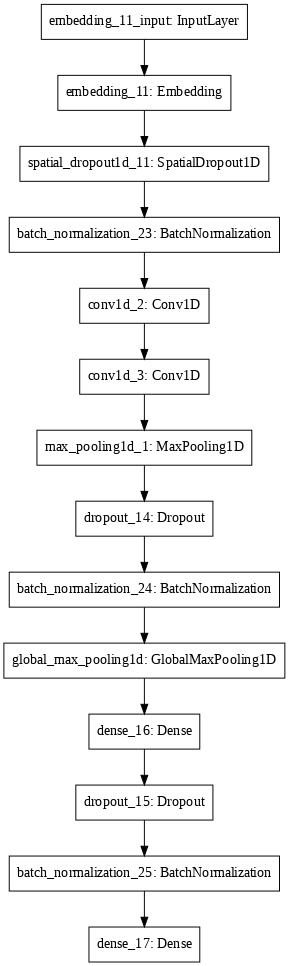

In [ ]:
model_Conv_4 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_Conv_4.add(Embedding(200000, 50, input_length=1000))

model_Conv_4.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_Conv_4.add(BatchNormalization())  # добавляем слой нормализации данных
model_Conv_4.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_Conv_4.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_Conv_4.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_4.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_4.add(GlobalMaxPooling1D()) # добавляем слой подвыборки/пулинга с функцией максимума(по всей длине входящей последовательности)
#modelEC.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_Conv_4.add(Dense(20, activation="relu")) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_Conv_4.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_Conv_4.add(BatchNormalization()) # добавляем слой нормализации данных
model_Conv_4.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_Conv_4.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_Conv_4.summary()
print()
plot_model(model_Conv_2, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_Conv_4.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=200,
                    validation_data=(xTest, yTest))

Epoch 1/100
89/89 [==============================] - 7s 62ms/step - loss: 1.4730 - accuracy: 0.4402 - val_loss: 1.7164 - val_accuracy: 0.2928
Epoch 2/100
89/89 [==============================] - 5s 59ms/step - loss: 0.5140 - accuracy: 0.8970 - val_loss: 1.7777 - val_accuracy: 0.2940
Epoch 3/100
89/89 [==============================] - 5s 57ms/step - loss: 0.2380 - accuracy: 0.9650 - val_loss: 1.8850 - val_accuracy: 0.3229
Epoch 4/100
89/89 [==============================] - 5s 61ms/step - loss: 0.1316 - accuracy: 0.9829 - val_loss: 1.9191 - val_accuracy: 0.3130
Epoch 5/100
89/89 [==============================] - 5s 61ms/step - loss: 0.0818 - accuracy: 0.9869 - val_loss: 1.9278 - val_accuracy: 0.3493
Epoch 6/100
89/89 [==============================] - 5s 60ms/step - loss: 0.0588 - accuracy: 0.9896 - val_loss: 1.9149 - val_accuracy: 0.3870
Epoch 7/100
89/89 [==============================] - 5s 59ms/step - loss: 0.0423 - accuracy: 0.9926 - val_loss: 1.9202 - val_accuracy: 0.4155
Epoch 

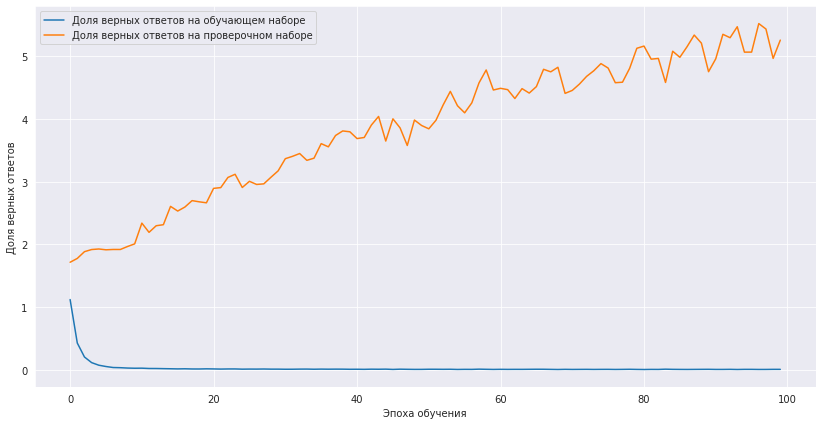

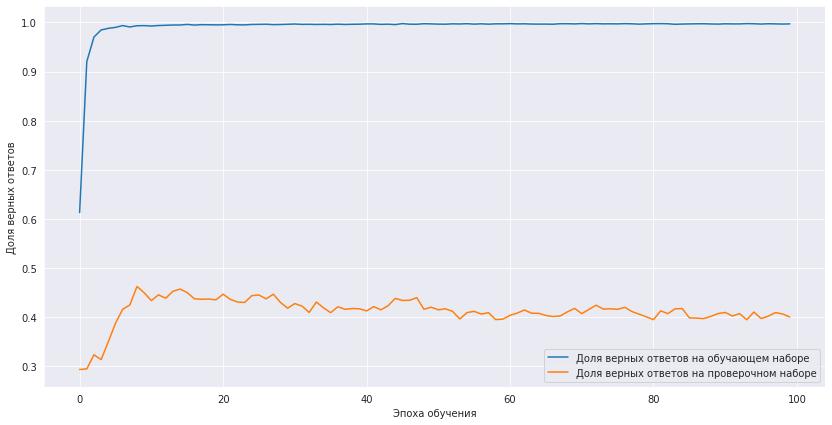

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_Conv_4, xTest6Classes, "Embedding + Conv") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv

О. Генри  распознано  79 % сеть считает, что это  О. Генри ,  распознано ВЕРНО!
Стругацкие  распознано  12 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Булгаков  распознано  5 % сеть считает, что это  Фрай ,  распознано НЕ ВЕРНО!
Саймак  распознано  26 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!
Фрай  распознано  81 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  24 % сеть считает, что это  О. Генри ,  распознано НЕ ВЕРНО!

Средний процент распознавания  39 %



### LSTM + Conv1D

####**Иссл. №21**

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 1000, 10)          0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 1000, 4)           240       
_________________________________________________________________
dense_22 (Dense)             (None, 1000, 100)         500       
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 996, 20)           10020     
_________________________________________________________________
lstm_16 (LSTM)               (None, 996, 4)            400       
_________________________________________________________________
dropout_21 (Dropout)         (None, 996, 4)          

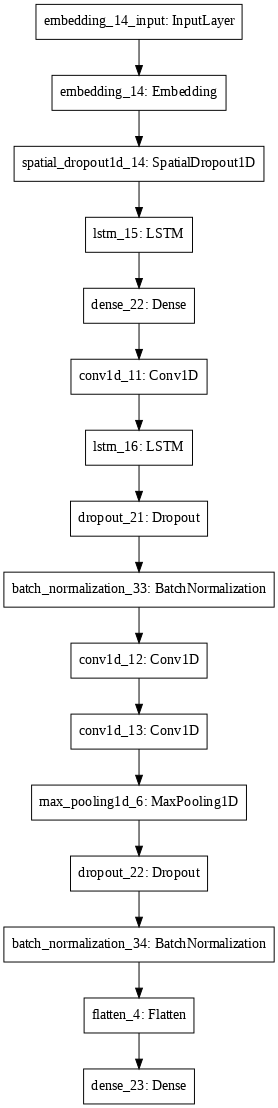

In [ ]:
model_LC_1 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LC_1.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_LC_1.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LC_1.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LC_1.add(Dense(100, activation='relu')) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_LC_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_1.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LC_1.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_1.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_1.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_LC_1.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_1.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_1.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_LC_1.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LC_1.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LC_1.summary()
print()
plot_model(model_LC_1, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LC_1.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=200,
                    validation_data=(xTest, yTest))

Epoch 1/100
89/89 [==============================] - 17s 146ms/step - loss: 1.2893 - accuracy: 0.4923 - val_loss: 2.7267 - val_accuracy: 0.0738
Epoch 2/100
89/89 [==============================] - 12s 138ms/step - loss: 0.1261 - accuracy: 0.9576 - val_loss: 3.1502 - val_accuracy: 0.0741
Epoch 3/100
89/89 [==============================] - 12s 136ms/step - loss: 0.0364 - accuracy: 0.9882 - val_loss: 5.6366 - val_accuracy: 0.1168
Epoch 4/100
89/89 [==============================] - 12s 136ms/step - loss: 0.0406 - accuracy: 0.9884 - val_loss: 5.1754 - val_accuracy: 0.1687
Epoch 5/100
89/89 [==============================] - 12s 136ms/step - loss: 0.0202 - accuracy: 0.9937 - val_loss: 17.9766 - val_accuracy: 0.1624
Epoch 6/100
89/89 [==============================] - 12s 135ms/step - loss: 0.0273 - accuracy: 0.9927 - val_loss: 10.3864 - val_accuracy: 0.3259
Epoch 7/100
89/89 [==============================] - 12s 137ms/step - loss: 0.0117 - accuracy: 0.9966 - val_loss: 8.3843 - val_accurac

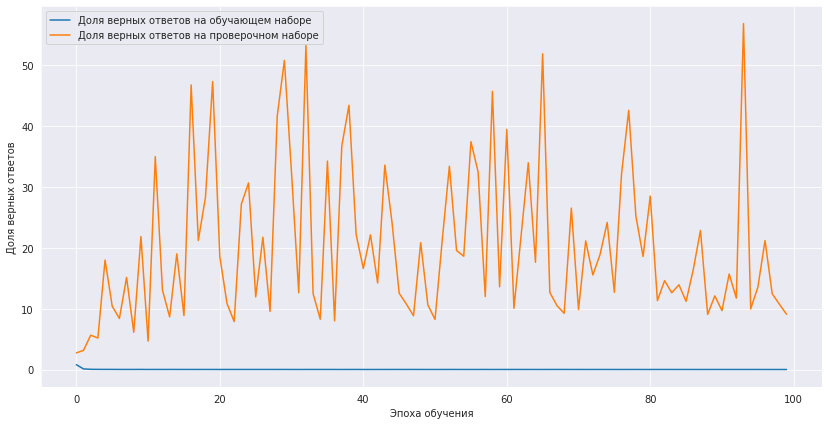

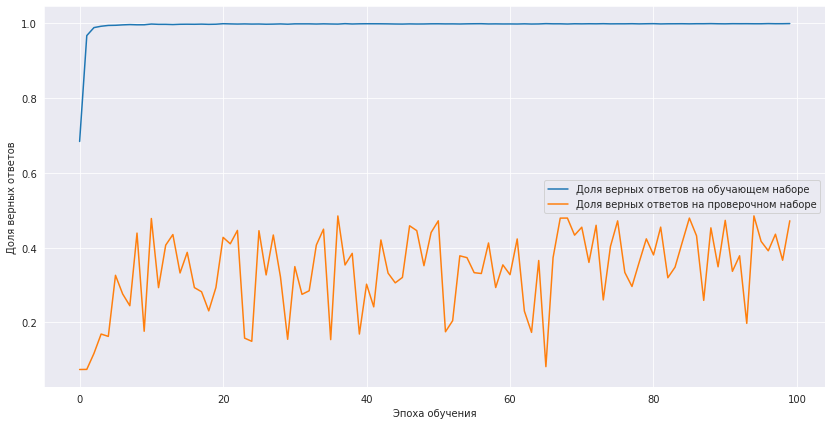

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_LC_1, xTest6Classes, "Embedding + Conv + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv + LSTM

О. Генри  распознано  10 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  21 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  69 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  52 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  68 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  27 % сеть считает, что это  Стругацкие ,  распознано НЕ ВЕРНО!

Средний процент распознавания  47 %



####**Иссл. №22**

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 1000, 10)          0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 1000, 4)           240       
_________________________________________________________________
dense_24 (Dense)             (None, 1000, 100)         500       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 996, 20)           10020     
_________________________________________________________________
lstm_18 (LSTM)               (None, 996, 4)            400       
_________________________________________________________________
dropout_23 (Dropout)         (None, 996, 4)          

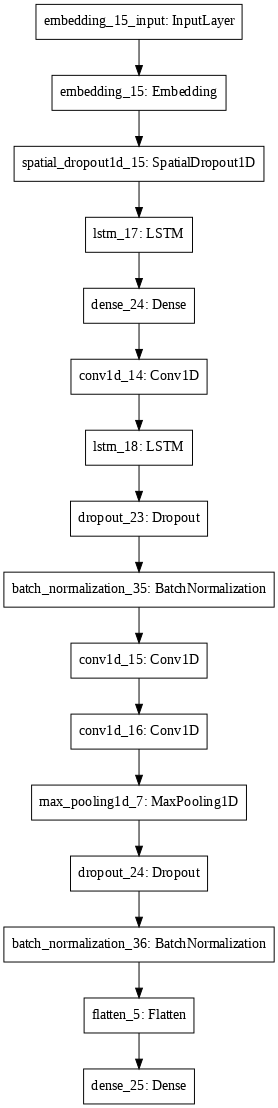

In [ ]:
model_LC_2 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LC_2.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_LC_2.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LC_2.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LC_2.add(Dense(100, activation='relu')) # добавляем полносвязный слой с указанием количества нейронов и функции активации
model_LC_2.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_2.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LC_2.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_2.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_2.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров 
model_LC_2.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_LC_2.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_2.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_2.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_LC_2.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LC_2.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model_LC_2.summary()
print()
plot_model(model_LC_2, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LC_2.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=200,
                    validation_data=(xTest, yTest))

Epoch 1/100
89/89 [==============================] - 17s 142ms/step - loss: 1.3516 - accuracy: 0.4434 - val_loss: 3.7694 - val_accuracy: 0.1611
Epoch 2/100
89/89 [==============================] - 12s 132ms/step - loss: 0.0880 - accuracy: 0.9704 - val_loss: 4.4277 - val_accuracy: 0.0740
Epoch 3/100
89/89 [==============================] - 12s 132ms/step - loss: 0.0324 - accuracy: 0.9891 - val_loss: 5.2065 - val_accuracy: 0.3640
Epoch 4/100
89/89 [==============================] - 12s 133ms/step - loss: 0.0171 - accuracy: 0.9956 - val_loss: 5.5827 - val_accuracy: 0.3653
Epoch 5/100
89/89 [==============================] - 12s 133ms/step - loss: 0.0150 - accuracy: 0.9957 - val_loss: 5.7313 - val_accuracy: 0.2352
Epoch 6/100
89/89 [==============================] - 12s 134ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 12.2507 - val_accuracy: 0.3256
Epoch 7/100
89/89 [==============================] - 12s 132ms/step - loss: 0.0129 - accuracy: 0.9963 - val_loss: 3.0965 - val_accuracy

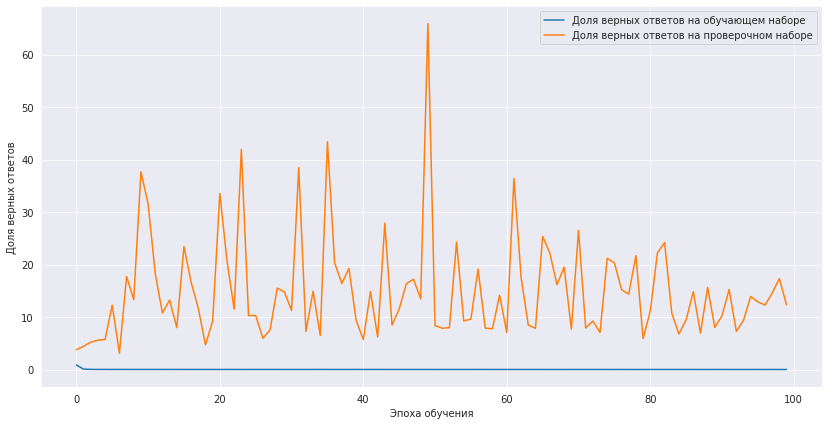

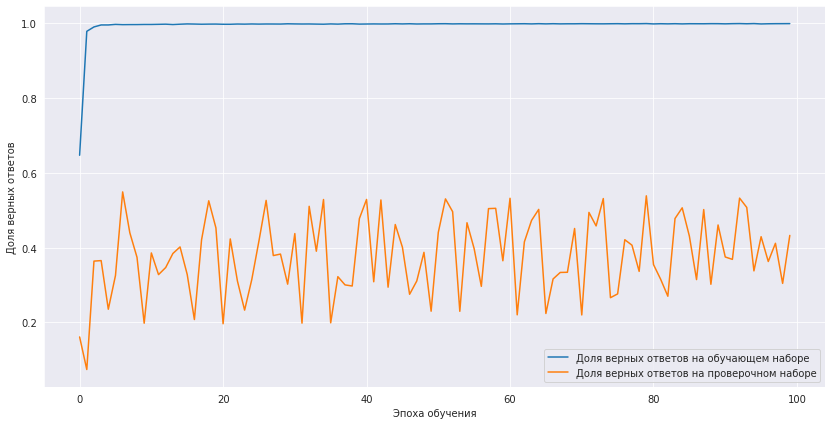

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_LC_2, xTest6Classes, "Embedding + Conv + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv + LSTM

О. Генри  распознано  4 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  10 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Булгаков  распознано  40 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Саймак  распознано  20 % сеть считает, что это  Брэдбери ,  распознано НЕ ВЕРНО!
Фрай  распознано  53 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  80 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  43 %



####**Иссл. №23**

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 1000, 10)          200000    
_________________________________________________________________
spatial_dropout1d_16 (Spatia (None, 1000, 10)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 996, 20)           1020      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 498, 20)           0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 498, 20)           0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 498, 20)           80        
_________________________________________________________________
lstm_19 (LSTM)               (None, 498, 4)          

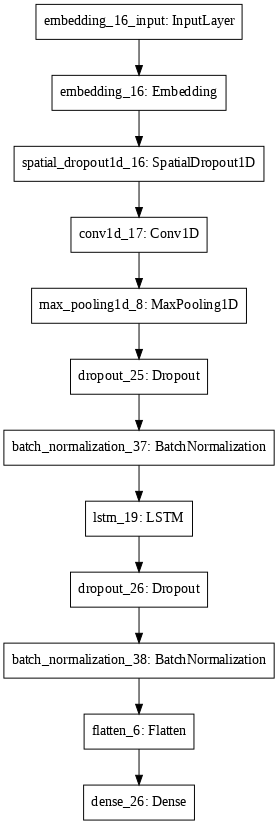

In [ ]:
model_LC_3 = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
model_LC_3.add(Embedding(maxWordsCount, 10, input_length=xLen))

model_LC_3.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
model_LC_3.add(Conv1D(20, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
model_LC_3.add(MaxPooling1D(2)) # добавляем слой подвыборки/пулинга с функцией максимума
model_LC_3.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_3.add(LSTM(4, return_sequences=1)) # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
model_LC_3.add(Dropout(0.2)) # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
model_LC_3.add(BatchNormalization()) # добавляем слой нормализации данных
model_LC_3.add(Flatten()) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
model_LC_3.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# Компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
model_LC_3.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model_LC_3.summary()
print()
plot_model(model_LC_3, dpi=70)

In [ ]:
# Обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети, и тестовой выборки
history = model_LC_3.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=200,
                    validation_data=(xTest, yTest))

Epoch 1/100
89/89 [==============================] - 7s 46ms/step - loss: 1.4910 - accuracy: 0.4608 - val_loss: 2.7588 - val_accuracy: 0.0738
Epoch 2/100
89/89 [==============================] - 4s 40ms/step - loss: 0.0950 - accuracy: 0.9678 - val_loss: 3.5173 - val_accuracy: 0.2604
Epoch 3/100
89/89 [==============================] - 3s 39ms/step - loss: 0.0196 - accuracy: 0.9936 - val_loss: 5.0645 - val_accuracy: 0.2668
Epoch 4/100
89/89 [==============================] - 4s 40ms/step - loss: 0.0124 - accuracy: 0.9960 - val_loss: 9.5529 - val_accuracy: 0.2235
Epoch 5/100
89/89 [==============================] - 4s 40ms/step - loss: 0.0110 - accuracy: 0.9966 - val_loss: 7.7235 - val_accuracy: 0.3021
Epoch 6/100
89/89 [==============================] - 4s 39ms/step - loss: 0.0124 - accuracy: 0.9963 - val_loss: 5.3810 - val_accuracy: 0.3680
Epoch 7/100
89/89 [==============================] - 4s 40ms/step - loss: 0.0084 - accuracy: 0.9976 - val_loss: 2.9713 - val_accuracy: 0.4917
Epoch 

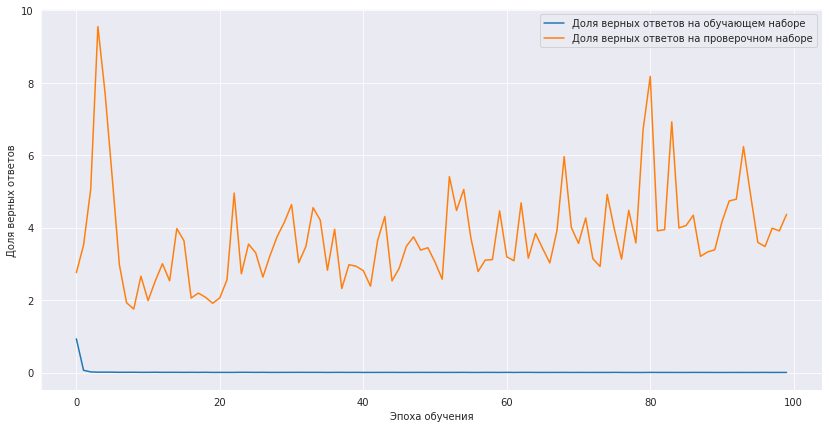

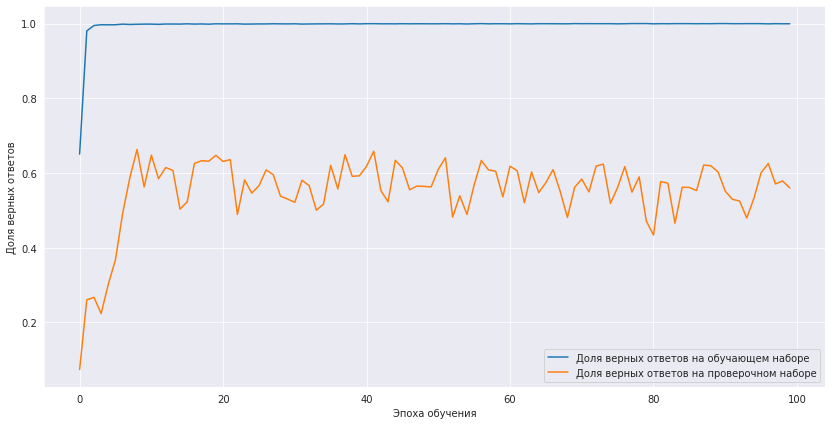

In [ ]:
# Строим график для отображения динамики ошибки работы модели
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], 
         label='Значение ошибки на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Значение ошибки на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.show()

# Строим график для отображения динамики обучения и точности предсказания сети
plt.figure(figsize = (14, 7))
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
pred = recognizeMultiClass(model_LC_3, xTest6Classes, "Embedding + Conv + LSTM") #функция покажет какие классы и как распознаны верно

НЕЙРОНКА:  Embedding + Conv + LSTM

О. Генри  распознано  18 % сеть считает, что это  Булгаков ,  распознано НЕ ВЕРНО!
Стругацкие  распознано  61 % сеть считает, что это  Стругацкие ,  распознано ВЕРНО!
Булгаков  распознано  44 % сеть считает, что это  Булгаков ,  распознано ВЕРНО!
Саймак  распознано  45 % сеть считает, что это  Саймак ,  распознано ВЕРНО!
Фрай  распознано  89 % сеть считает, что это  Фрай ,  распознано ВЕРНО!
Брэдбери  распознано  32 % сеть считает, что это  Брэдбери ,  распознано ВЕРНО!

Средний процент распознавания  55 %

